# Homework 1. Which of two things is larger?

Due: Thursday, September 19, 11:59 PM

<a href=https://raw.github.com/cs109/content/master/HW1.ipynb download=HW1.ipynb> Download this assignment</a>

---

Useful libraries for this assignment

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting
* [requests](http://docs.python-requests.org/en/latest/), for downloading web content
* [pattern](http://www.clips.ua.ac.be/pages/pattern), for parsing html and xml pages
* [fnmatch](http://docs.python.org/2/library/fnmatch.html) (optional), for Unix-style string matching

In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web


# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

/Users/ben/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Introduction

This was the [XKCD comic](http://xkcd.com/1131/) after the 2012 Presidential election:

<img src="http://imgs.xkcd.com/comics/math.png">

The comic refers to the fact that Nate Silver's statistical model (which is based mostly on combining information from pre-election polls) correctly predicted the outcome of the 2012 presidential race in all 50 states. 

Polling data isn't a perfect predictor for the future, and some polls are more accurate than others. This means that election forecastors must consider prediction uncertainty when building models.

In this first assignment, you will perform a simple analysis of polling data about the upcoming <a href="http://en.wikipedia.org/wiki/Governor_(United_States)">Governor races</a>. The assignment has three main parts:

**First** you will build some tools to download historical polling data from the web, and parse it into a more convenient format. 

**Next** you will use these tools to aggregate and visualize several past Governor races

**Finally** you will run a bootstrap analysis to estimate the probable outcome of current Governor races, given the level of precision of historical polls.

---



## Part 1: Collect and Clean

The [Real Clear Politics](http://www.realclearpolitics.com) website archives many political polls. In addition, they combine related polls to form an "RCP average" estimate of public opinion over time. For example, the chart on [this page](http://www.realclearpolitics.com/epolls/2012/president/us/general_election_romney_vs_obama-1171.html) shows historical polling data for the Obama-Romney presidential race. The chart is an average of the polling data table below the chart.

The data used to generate plots like this are stored as XML pages, with URLs like:

http://charts.realclearpolitics.com/charts/[id].xml

Here, [id] is a unique integer, found at the end of the URL of the page that displays the graph. The id for the Obama-Romney race is 1171:

http://charts.realclearpolitics.com/charts/1171.xml

Opening this page in Google Chrome or Firefox will show you the XML content in an easy-to-read format. Notice that XML tags are nested inside each other, hierarchically (the jargony term for this is the "Document Object Model", or "DOM"). The first step of webscraping is almost always exploring the HTML/XML source in a browser, and getting a sense of this hierarchy.

---

#### Problem 0

The above XML page includes 5 distinct tags (one, for example, is `chart`). List these tags, and depict how they nest inside each other using an indented list. For example:

* Page
  * Section
     * Paragraph
  * Conclusion

*chart
    *series
        *value
    *graphs
        *graph
            *value

---
#### Problem 1

We want to download and work with poll data like this. Like most programming tasks, we will break this into many smaller, easier pieces

Fill in the code for the `get_poll_xml` function, that finds and downloads an XML page discussed above

**Hint** 

`requests.get("http://www.google.com").text` downloads the text from Google's homepage

In [4]:
"""
Function
--------
get_poll_xml

Given a poll_id, return the XML data as a text string

Inputs
------
poll_id : int
    The ID of the poll to fetch

Returns
-------
xml : str
    The text of the XML page for that poll_id

Example
-------
>>> get_poll_xml(1044)
u'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value>
...etc...
"""    
def get_poll_xml(poll_id):
    return requests.get("http://charts.realclearpolitics.com/charts/" + str(poll_id) + ".xml").text

#print get_poll_xml(1044)
#print str(1044)
#requests.get("http://charts.realclearpolitics.com/charts/1044.xml").text


Here are some other functions we'll use later. `plot_colors` contains hints about parsing XML data.

In [5]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result

print plot_colors(get_poll_xml(1044))

{u'Approve': u'#000000', u'Disapprove': u'#FF0000'}


---

#### Problem 2

Even though `get_poll_xml` pulls data from the web into Python, it does so as a block of text. This still isn't very useful. Use the `web` module in `pattern` to parse this text, and extract data into a pandas DataFrame.

**Hints**

* You might want create python lists for each column in the XML. Then, to turn these lists into a DataFrame, run

`pd.DataFrame({'column_label_1': list_1, 'column_label_2':list_2, ...})`

* use the pandas function `pd.to_datetime` to convert strings into dates

In [6]:
"""
    Function
    ---------
    rcp_poll_data

    Extract poll information from an XML string, and convert to a DataFrame

    Parameters
    ----------
    xml : str
        A string, containing the XML data from a page like 
        get_poll_xml(1044)
        
    Returns
    -------
    A pandas DataFrame with the following columns:
        date: The date for each entry
        title_n: The data value for the gid=n graph (take the column name from the `title` tag)
        
    This DataFrame should be sorted by date
        
    Example
    -------
    Consider the following simple xml page:
    
    <chart>
    <series>
    <value xid="0">1/27/2009</value>
    <value xid="1">1/28/2009</value>
    </series>
    <graphs>
    <graph gid="1" color="#000000" balloon_color="#000000" title="Approve">
    <value xid="0">63.3</value>
    <value xid="1">63.3</value>
    </graph>
    <graph gid="2" color="#FF0000" balloon_color="#FF0000" title="Disapprove">
    <value xid="0">20.0</value>
    <value xid="1">20.0</value>
    </graph>
    </graphs>
    </chart>
    
    Given this string, rcp_poll_data should return
    result = pd.DataFrame({'date': pd.to_datetime(['1/27/2009', '1/28/2009']), 
                           'Approve': [63.3, 63.3], 'Disapprove': [20.0, 20.0]})
"""
"""
#your code here
import pattern.web

t2 = pattern.web.Element(test_text)
node = pattern.web.Node(test_text, type = NODE)
print node.children
#print t2
#print t2.by_tag("value")
for a in t2('value')[:2]: # First <a class="title">.
    print str((a.content))
    """
from bs4 import BeautifulSoup

def rcp_poll_data(xml):
    soup = BeautifulSoup(xml)
    dates = []
    for value in soup.series.find_all("value"):
        dates.append(value.get_text())
    result = pd.DataFrame({'date': pd.to_datetime(dates)})
    ##############should be soup.graphs.children????
    for child in soup.graphs:
        title = child["title"]
        data = []
        for value in child.find_all("value"):
            #data.append(value.get_text())
            try:
                data.append(float(value.get_text()))
            except ValueError: 
                data.append(np.nan)
        result[title]=data
    result_clean = result.dropna()
    return result_clean.sort(['date'], ascending = True)


    

In [80]:
data = rcp_poll_data(test_text)
print data.dtypes
print data

date          datetime64[ns]
Approve              float64
Disapprove           float64
dtype: object
           date  Approve  Disapprove
0    2009-01-27     63.3        20.0
1    2009-01-28     63.3        20.0
2    2009-01-29     63.5        19.3
3    2009-01-30     63.5        19.3
4    2009-01-31     61.8        19.4
5    2009-02-01     61.8        19.4
6    2009-02-02     61.8        19.4
7    2009-02-03     61.8        19.4
8    2009-02-04     61.8        19.4
9    2009-02-05     61.8        19.4
10   2009-02-06     61.6        21.4
11   2009-02-07     61.6        21.4
12   2009-02-08     61.6        21.4
13   2009-02-09     65.4        22.6
14   2009-02-10     65.4        22.6
15   2009-02-11     64.2        23.3
16   2009-02-12     64.2        23.3
17   2009-02-13     64.2        23.3
18   2009-02-14     64.8        25.4
19   2009-02-15     65.5        25.5
20   2009-02-16     65.5        25.5
21   2009-02-17     65.5        25.5
22   2009-02-18     65.1        25.9
23   2009-0

/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:78: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


The output from `rcp_poll_data` is much more useful for analysis. For example, we can plot with it:

In [7]:
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%    
    norm = data[colors.keys()].sum(axis=1) / 100    
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")

If you've done everything right so far, the following code should reproduce the graph on [this page](http://www.realclearpolitics.com/epolls/other/president_obama_job_approval-1044.html)

/Users/ben/anaconda/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/ben/anaconda/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))
/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:79: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


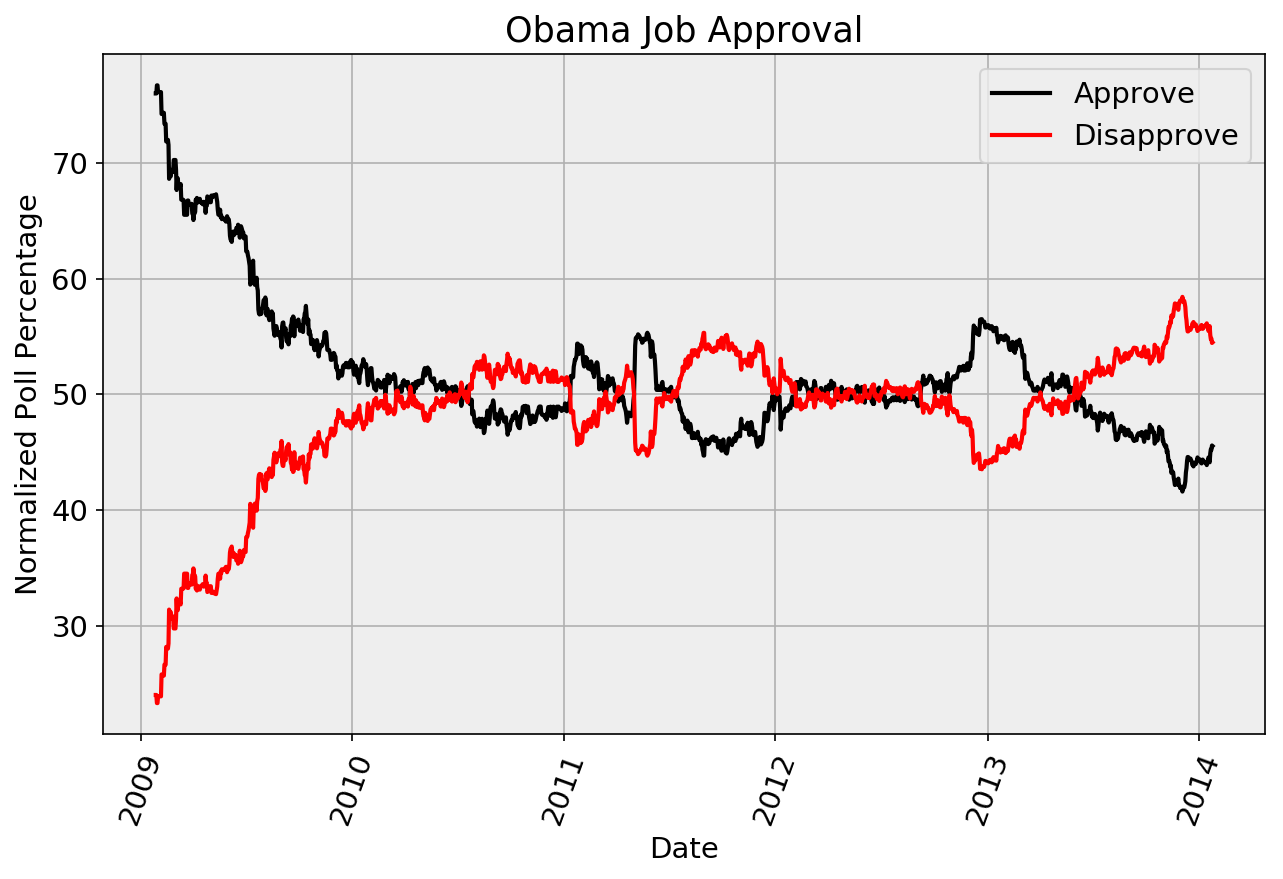

In [8]:
poll_plot(1044)
plt.title("Obama Job Approval")

---

## Part 2: Aggregate and Visualize


#### Problem 3

Unfortunately, these data don't have any error bars. If a candidate leads by 10% in the RCP average, is she a shoo-in to win? Or is this number too close to call? Does a 10% poll lead mean more 1 day before a race than it does 1 week before? Without error estimates, these questions are impossible to answer.

To get a sense of how accurate the RCP polls are, you will gather data from many previous Governor races, where the outcome is known.

This url has links to many governer races. 

http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html

Notice that each link to a governor race has the following URL pattern:

http://www.realclearpolitics.com/epolls/[YEAR]/governor/[STATE]/[TITLE]-[ID].html


Write a function that scans html for links to URLs like this

**Hint** The [fnmatch](http://docs.python.org/2/library/fnmatch.html) function is useful for simple string matching tasks.

In [31]:
"""
    Function
    --------
    find_governor_races

    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    
    Parameters
    ----------
    html : str
        The HTML content of a page to scan
        
    Returns
    -------
    A list of urls for Governer race pages
    
    Example
    -------
    For a page like
    
    <html>
    <body>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"></a>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"></a>
    </body>
    </html>
    
    find_governor_races would return
    ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']
"""
#your code here
"""
def find_governor_races(html):
    soup = BeautifulSoup(html)
    #print soup.prettify()
    head = soup.find("select", class_="search_by_race")
    #print head.prettify()
    list_of_urls = []
    for possible_link in head.find_all("option"):
        link = possible_link.get("value")
        if link.find("html") != -1:
            list_of_urls.append(link)
    return list_of_urls
"""
def find_governor_races(html):
    html = requests.get("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html").text
    soup = BeautifulSoup(html)
    #print soup.prettify()
    head = soup.find("div", class_="clearfix", id="states")
    list_of_urls = []
    for possible_link in head.find_all("a"):
        link = possible_link.get("href")
        if link.find("governor") != -1:
            list_of_urls.append("http://www.realclearpolitics.com" + link)
    return list_of_urls

In [32]:
print find_governor_races(requests.get("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html").text)

['http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html', 'http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html', 'http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html', 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html', 'http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html', 'http://www.realclearpolitics.com/epolls/2010/governor/co/colorado_governor_maes_vs_hickenlooper_vs_tancredo-1677.html', 'http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html', 'http://www.realclearpolitics.com/epolls/2010/governor/fl/florida_governor_scott_vs_sink_vs_chiles-1607.html', 'http://www.realclearpolitics.com/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html', 'http://www.realclear

#### Problem 4

At this point, you have functions to find a collection of governor races, download historical polling data from each one,
parse them into a numerical DataFrame, and plot this data.

The main question we have about these data are how accurately they predict election outcomes. To answer this question, we
need to grab the election outcome data.

Write a function that looks up and returns the election result on a page like [this one](http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html). 

**Remember to look at the HTML source!**

You can do this by selection `view->developer->view source` in Chrome, or `Tools -> web developer -> page source` in Firefox. Altenatively, you can right-click on a part of the page, and select "inspect element"

In [256]:
"""
    Function
    --------
    race_result

    Return the actual voting results on a race page
    
    Parameters
    ----------
    url : string
        The website to search through
        
    Returns
    -------
    A dictionary whose keys are candidate names,
    and whose values is the percentage of votes they received.
    
    If necessary, normalize these numbers so that they add up to 100%.
    
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
"""
#your code here


def race_result(url):
    soup = BeautifulSoup(requests.get(url).text)
    head = soup.find("tr", class_="final") 
    results = [result.get_text() for result in head.find_all("td")]
    names = [possible_name.get_text() for possible_name in head.find_previous_sibling("tr").find_all("th") ]
    names_cleaned = []
    for name in names:
        index = name.find("(")
        if index != -1:
            names_cleaned.append(name[:index-1])
        else:
            names_cleaned.append(name)
    results_dict = {}
    for index in range(3,len(names_cleaned)):
        if (names_cleaned[index].find("Spread") != -1) & (index > 4):
            break
        else: 
            results_dict.update({names_cleaned[index]: float(results[index])})
    
    #normalize
    sum = 0
    for key, value in results_dict.iteritems():
        sum += value
    for key, value in results_dict.iteritems():
        results_dict[key] = value*100./sum   
    return results_dict

url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
print race_result(url)

{u'Brown': 56.01265822784809, u'Whitman': 43.98734177215189}


notes: after looking at solutions, could use "final" tag to determine number of candidates

Here are some more utility functions that take advantage of what you've done so far.

In [257]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r], color=colors[_strip(r)], alpha=0.6, ls='--')


Now that this is done, we can easily visualize many historical Governer races. The solid line plots the poll history, the dotted line reports the actual result.

If this code block fails, you probably have a bug in one of your functions.

1568


/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:79: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


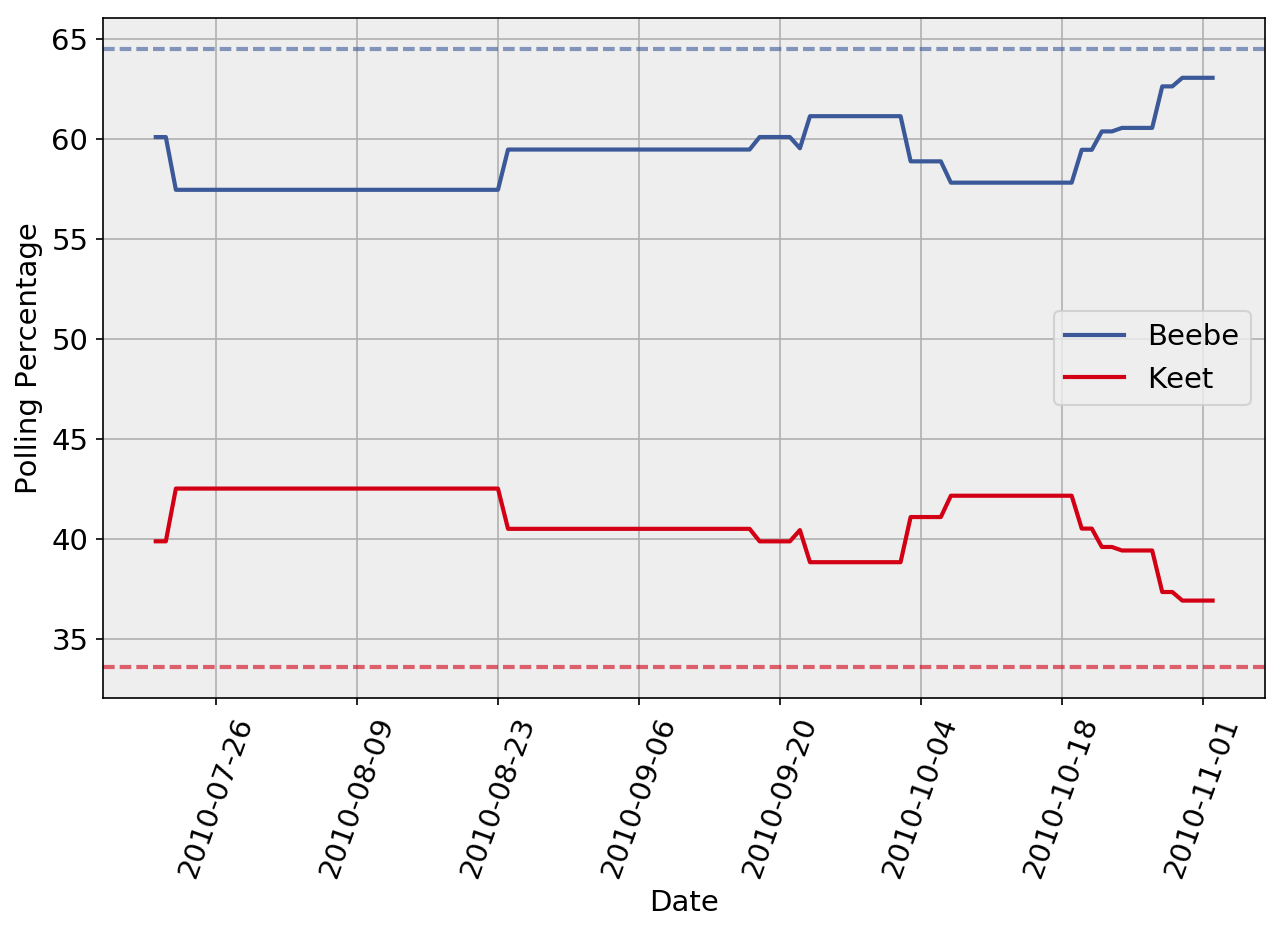

1121


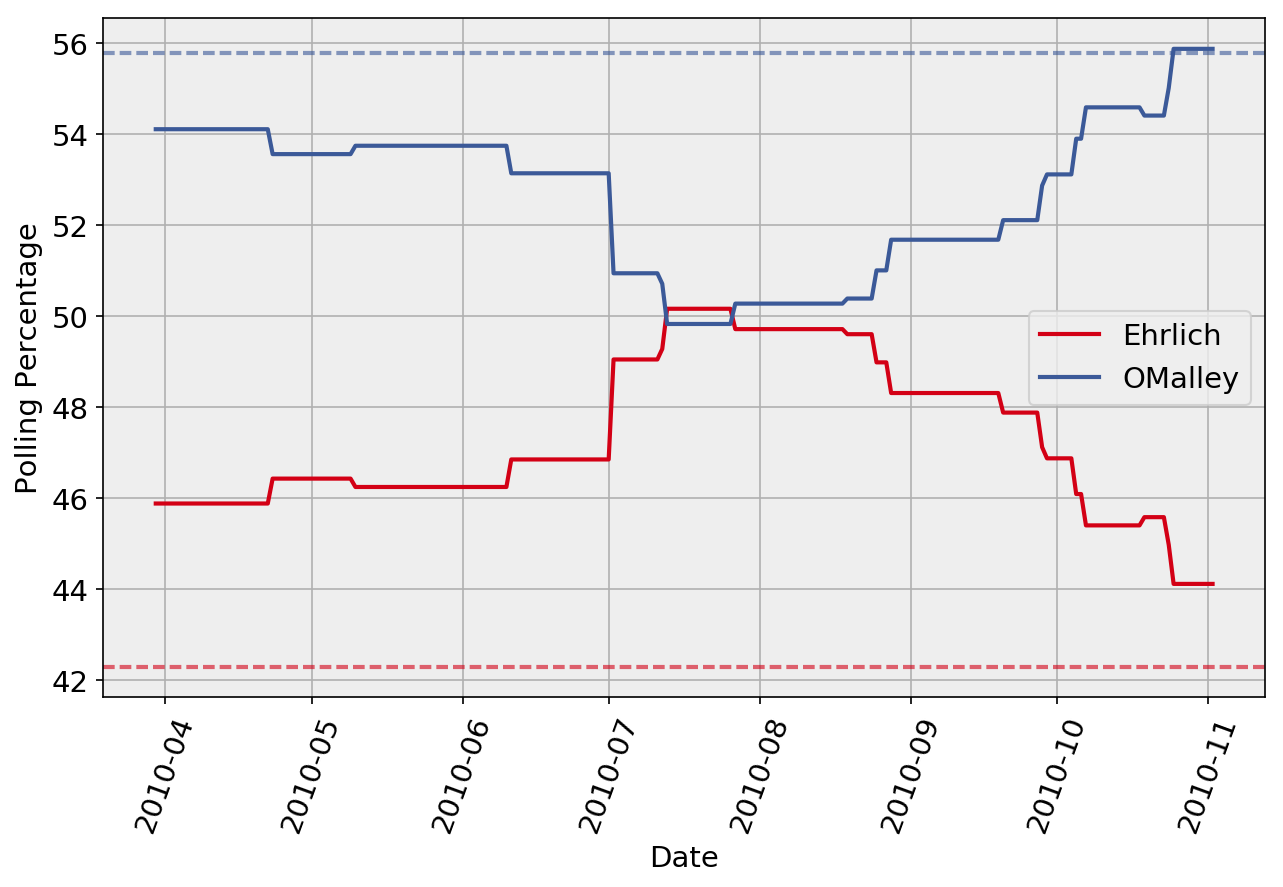

1423


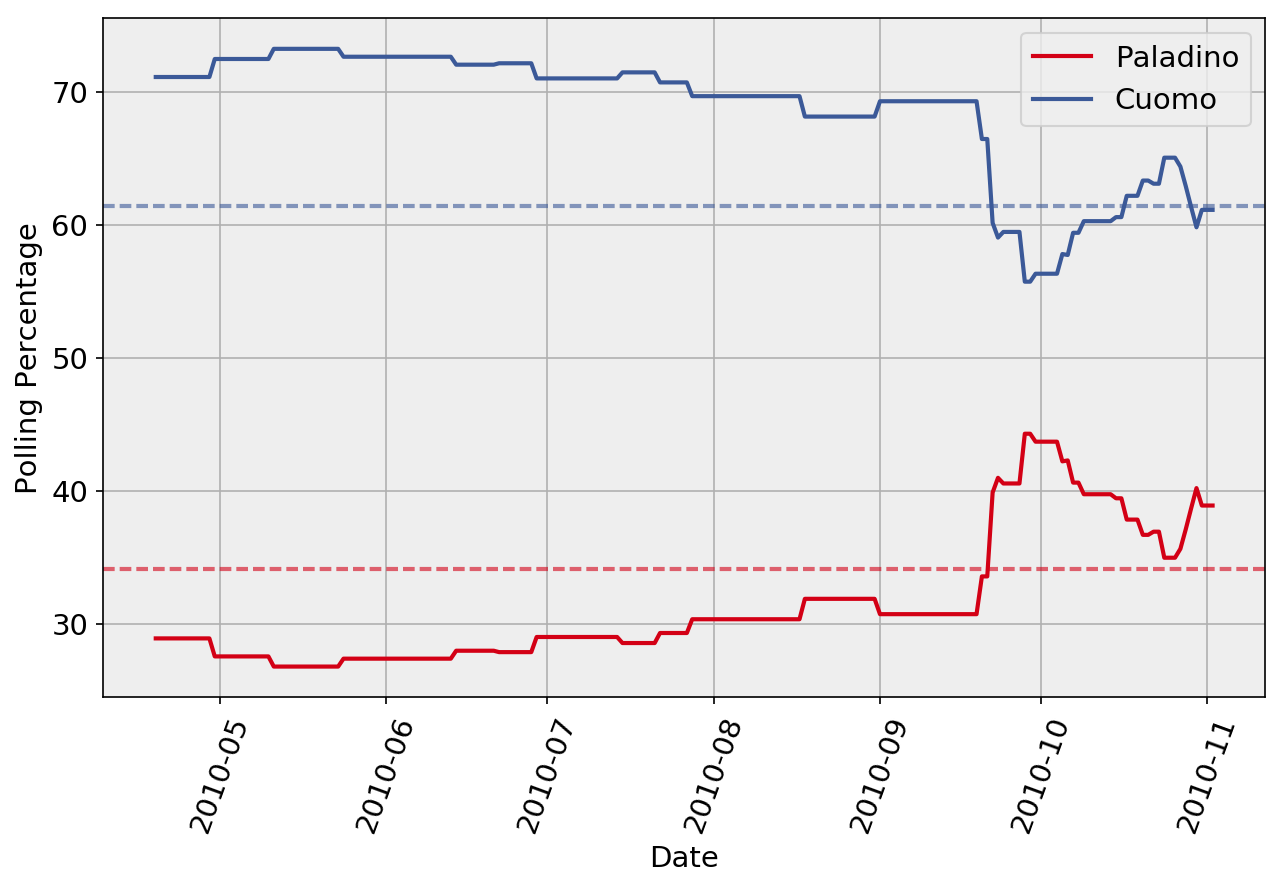

1113


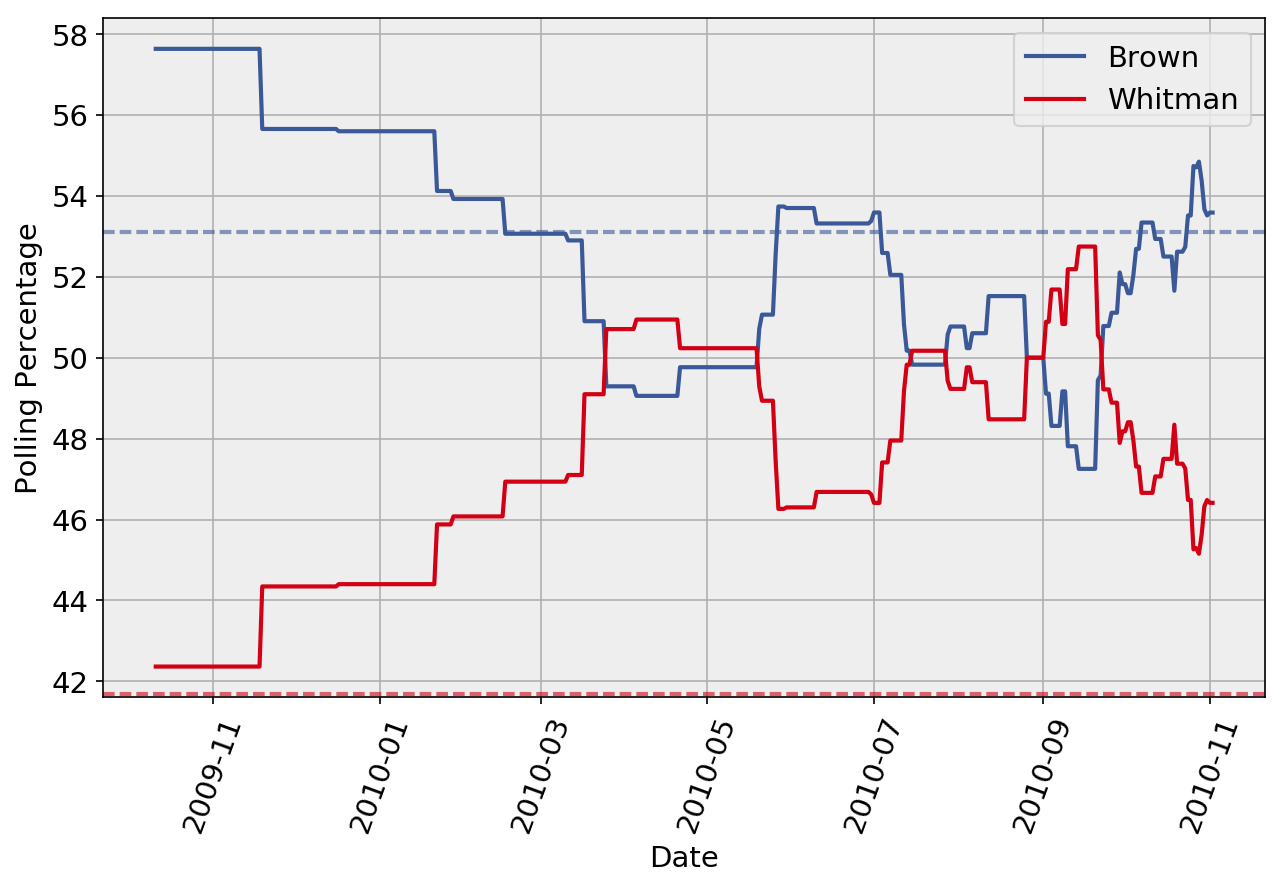

1446


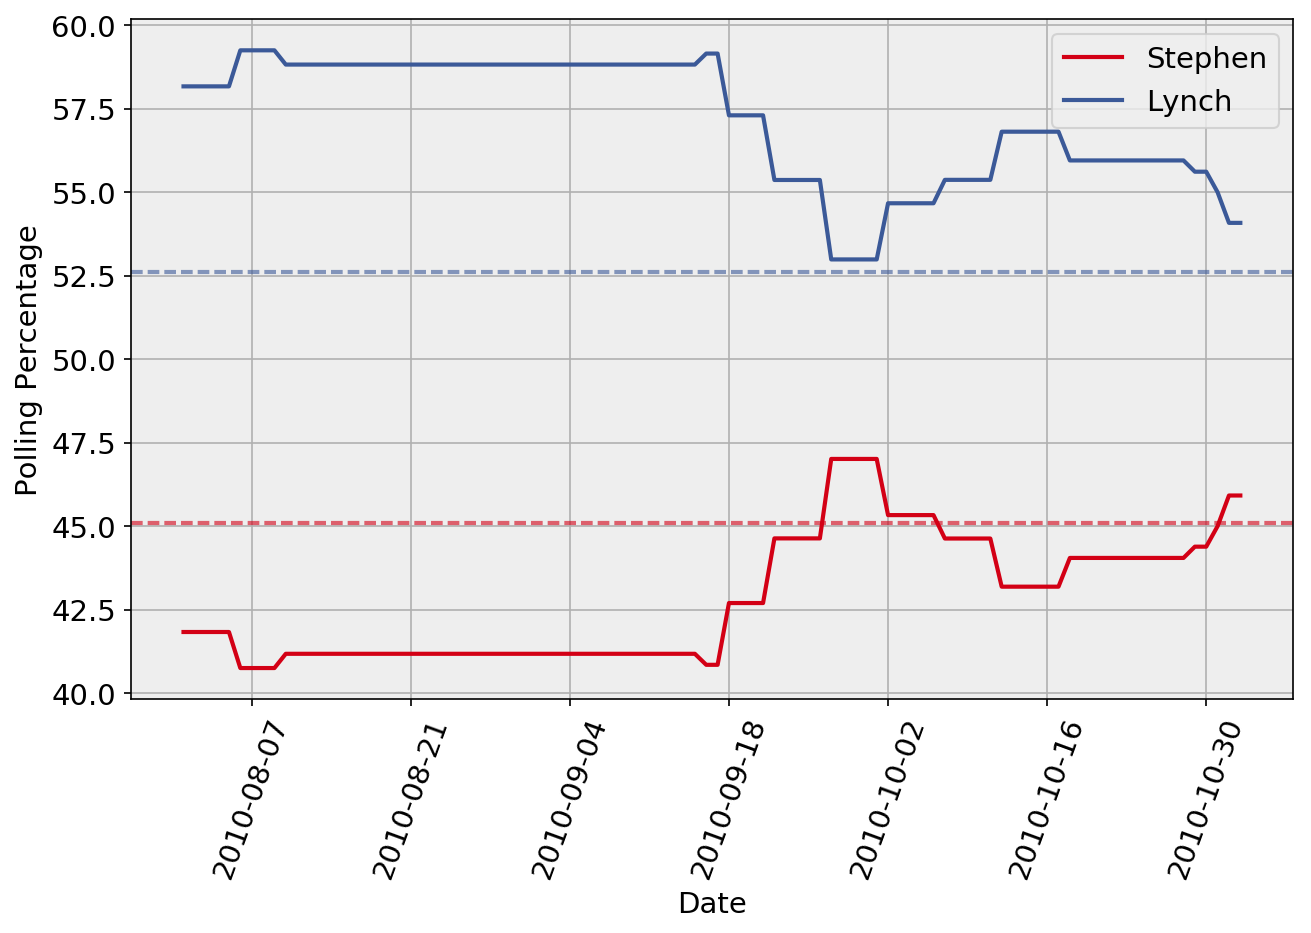

1677


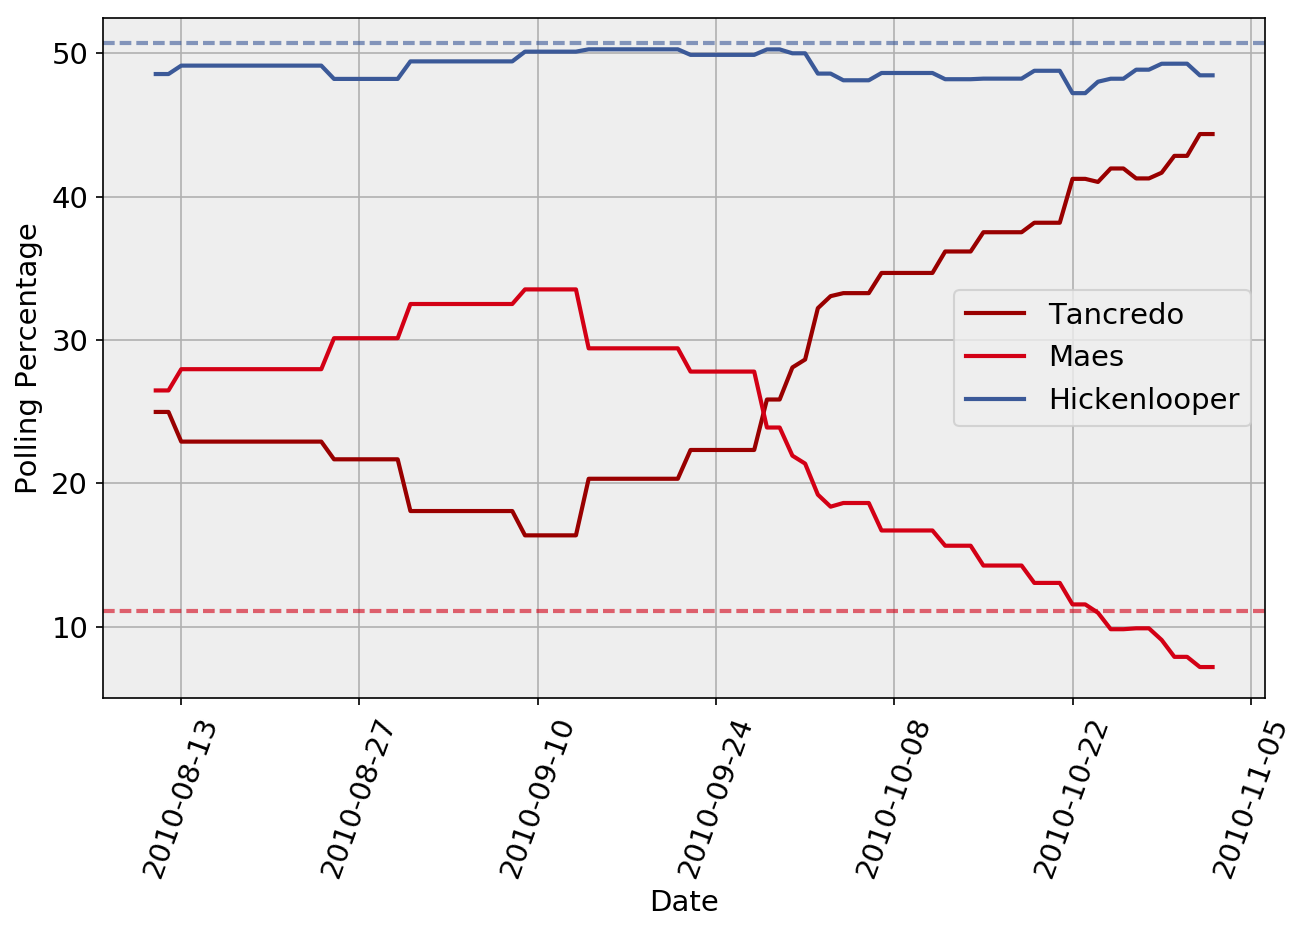

1357


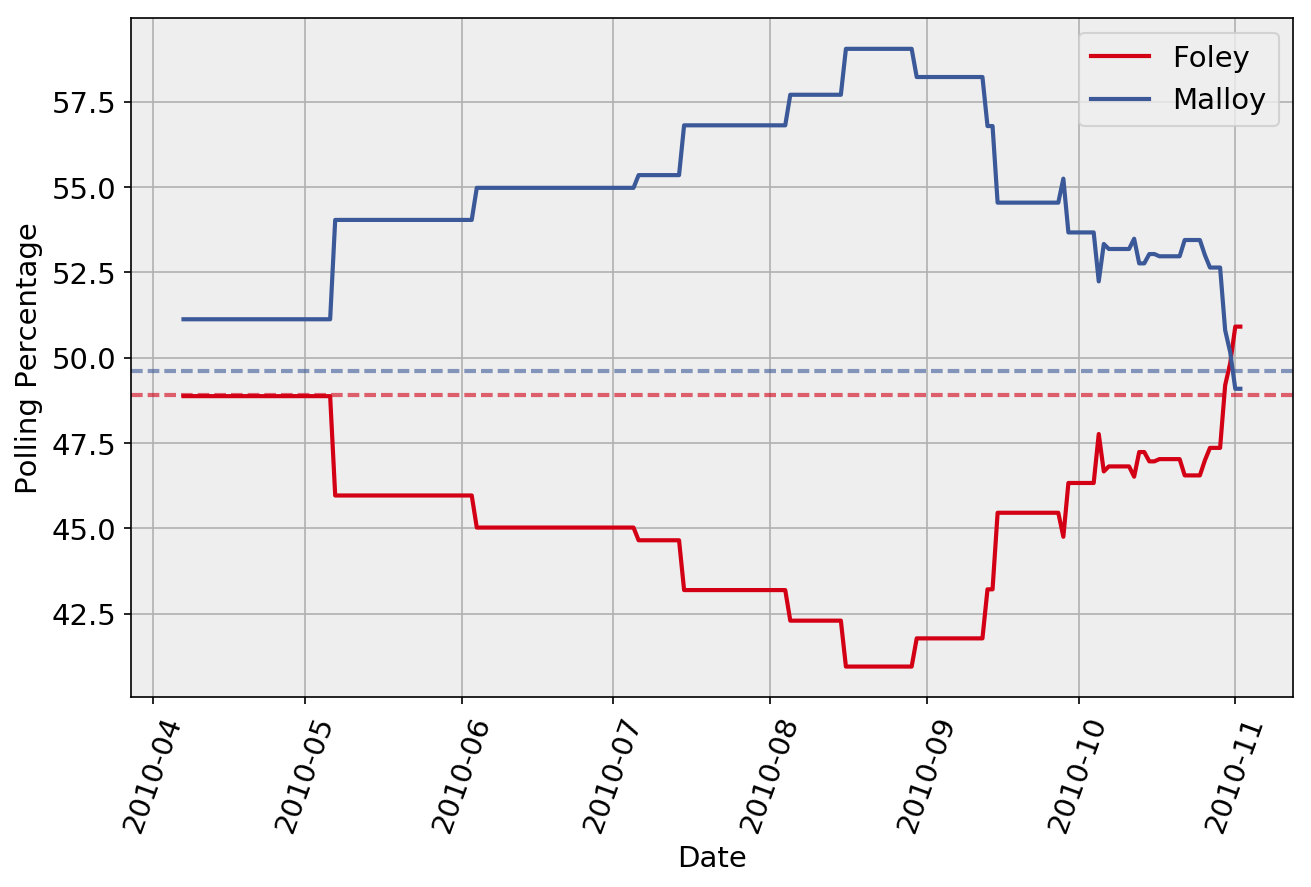

1607


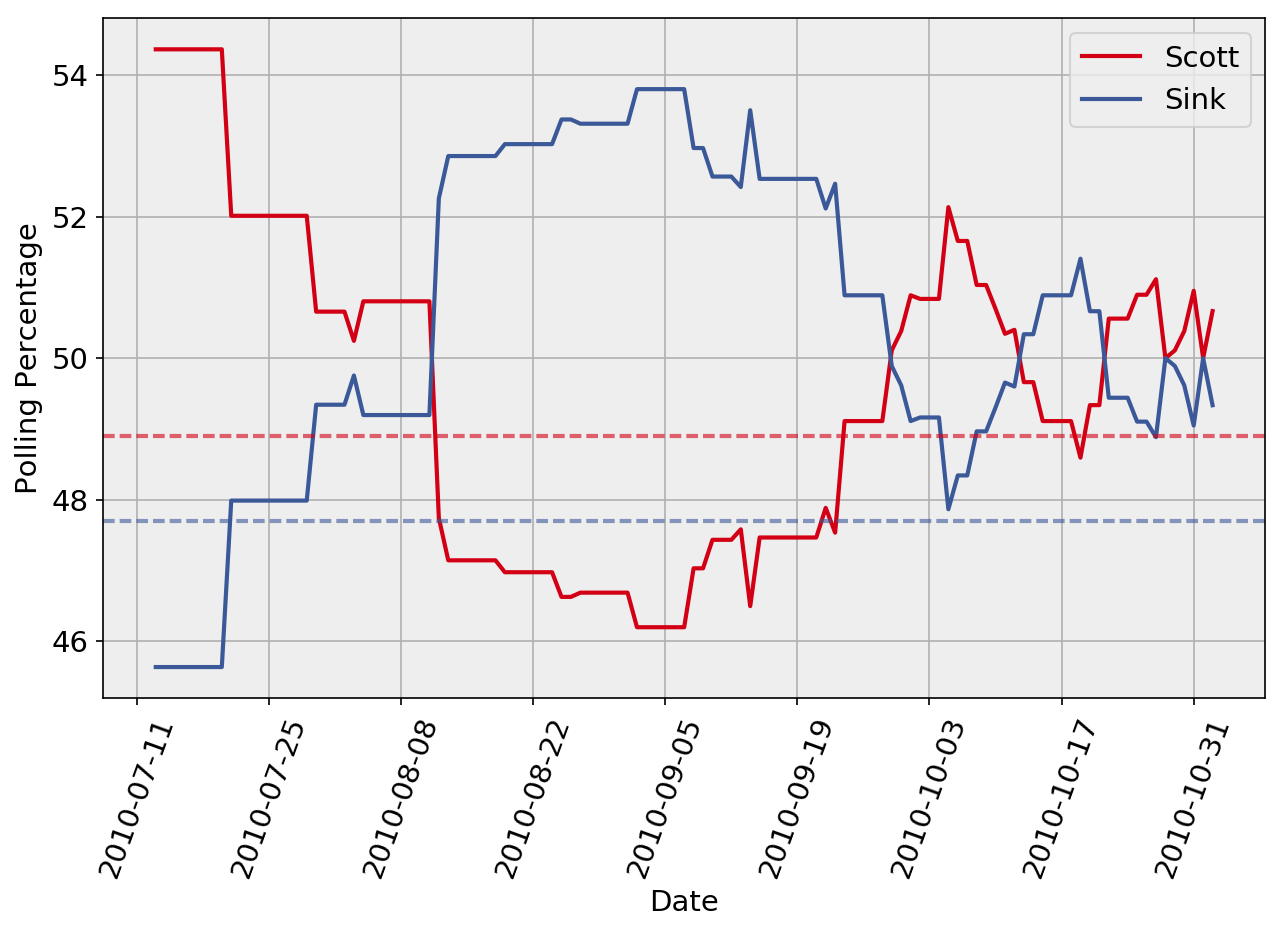

1163
1361


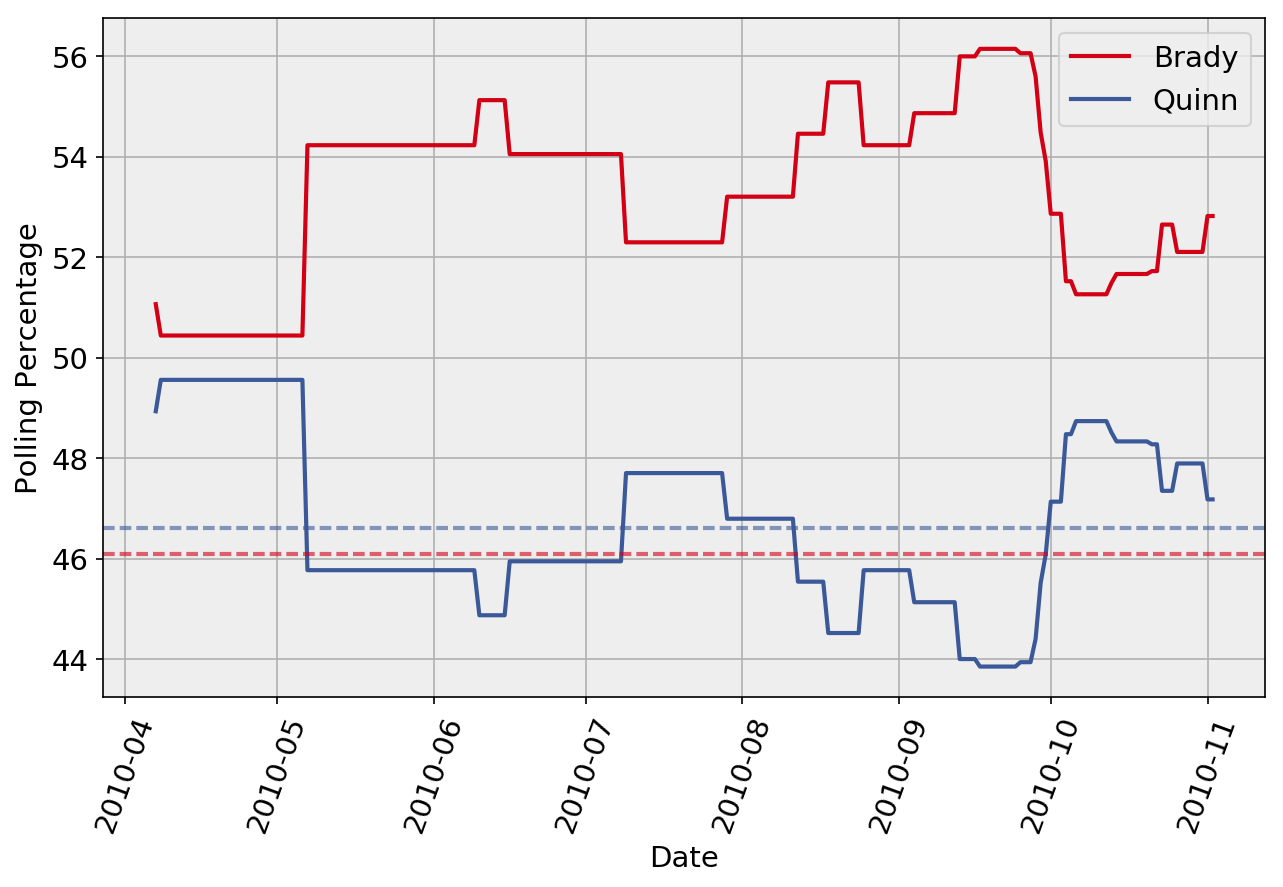

1154


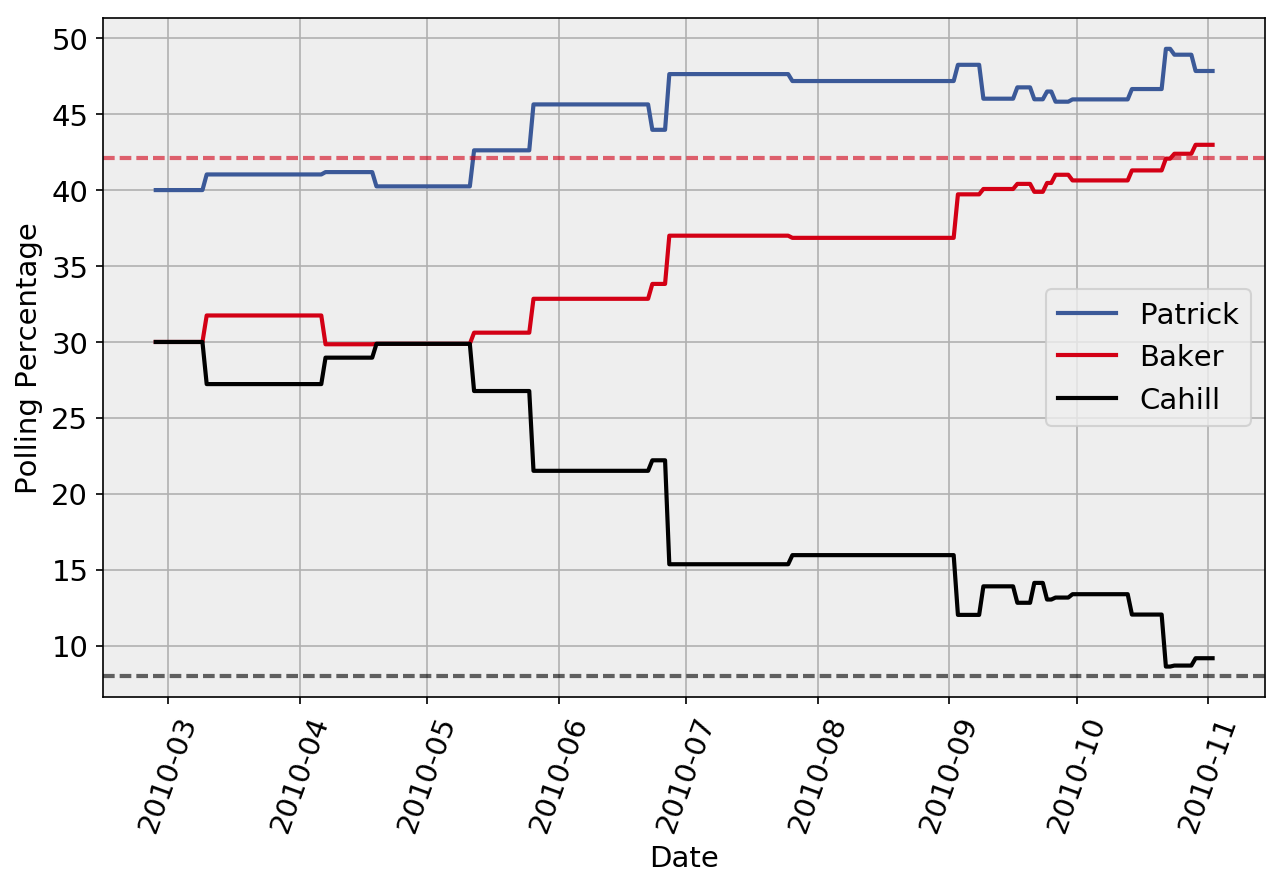

1393


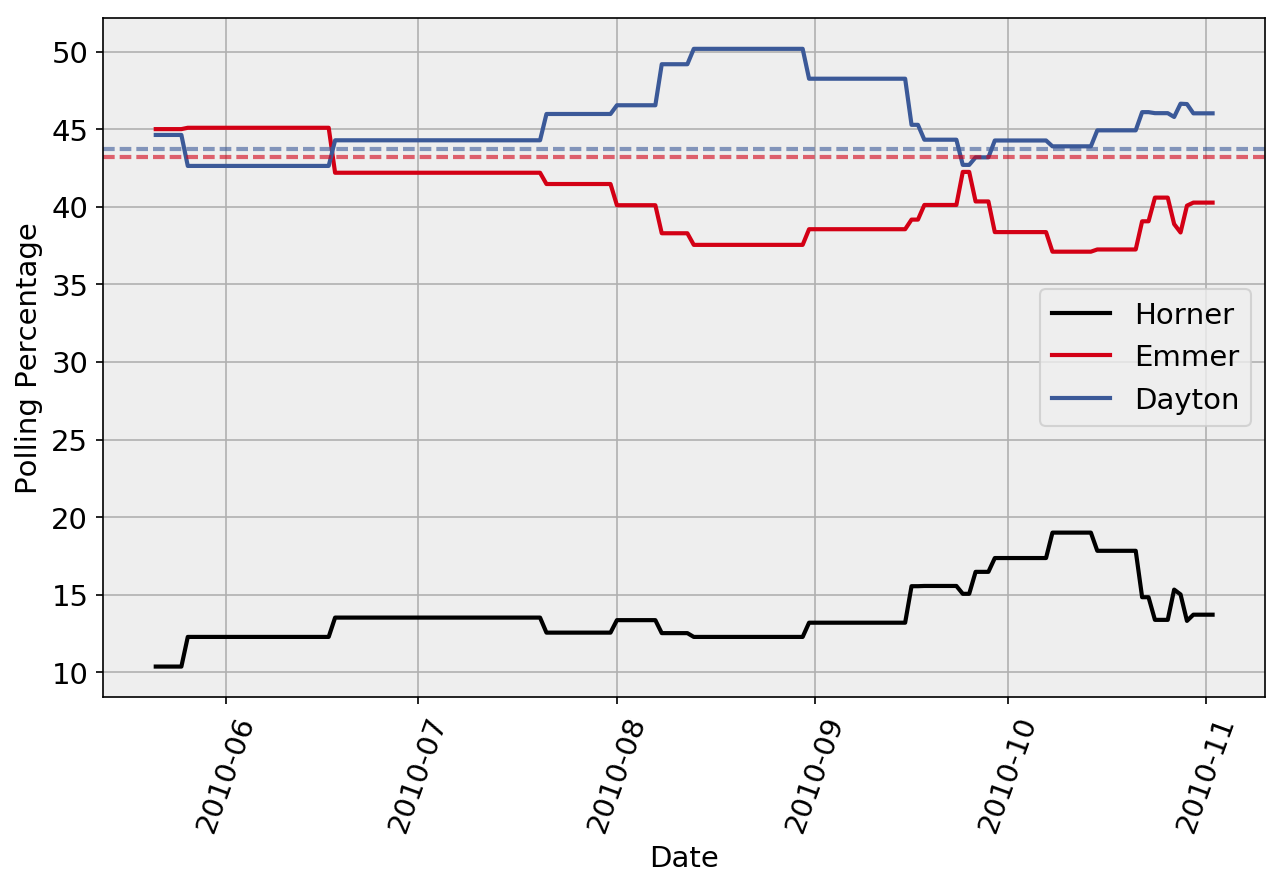

1078


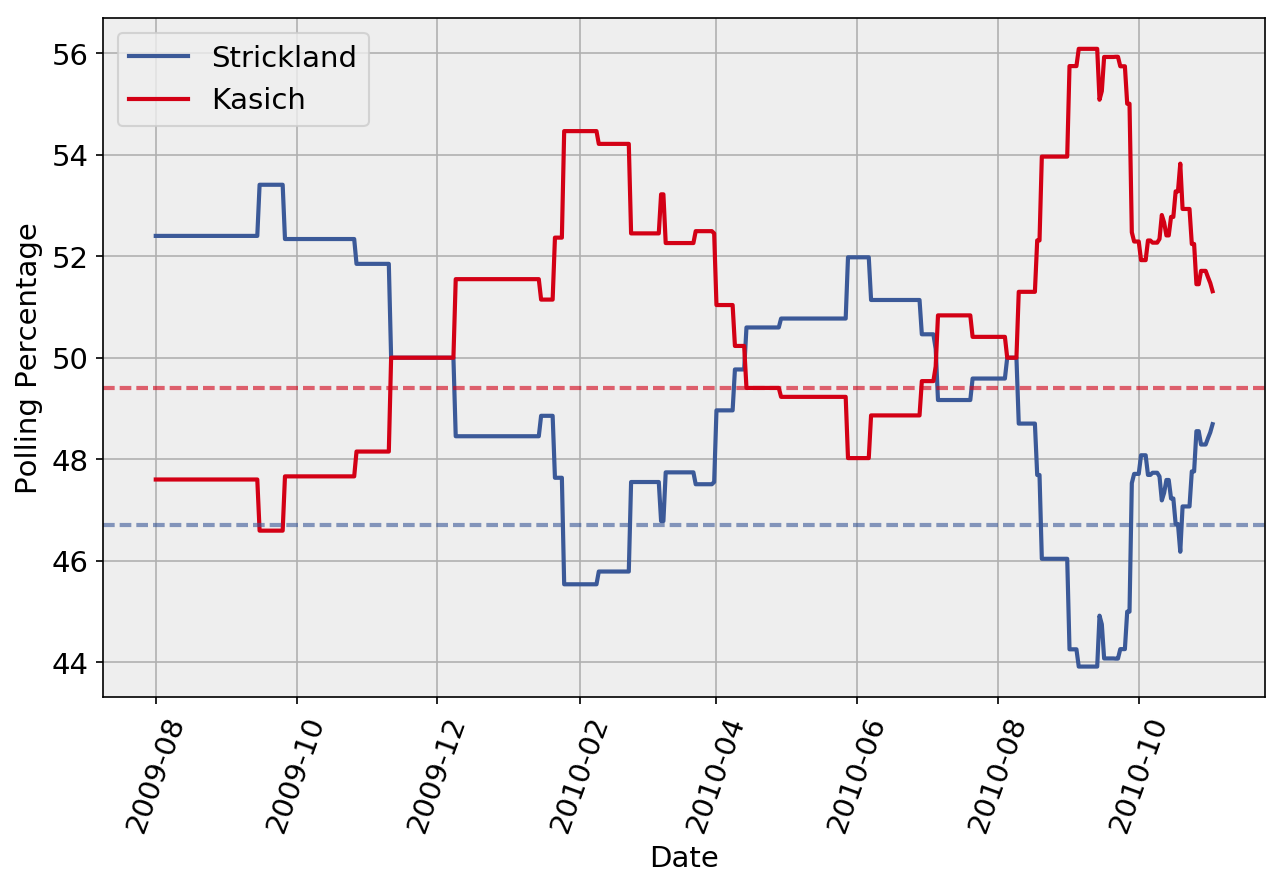

1088


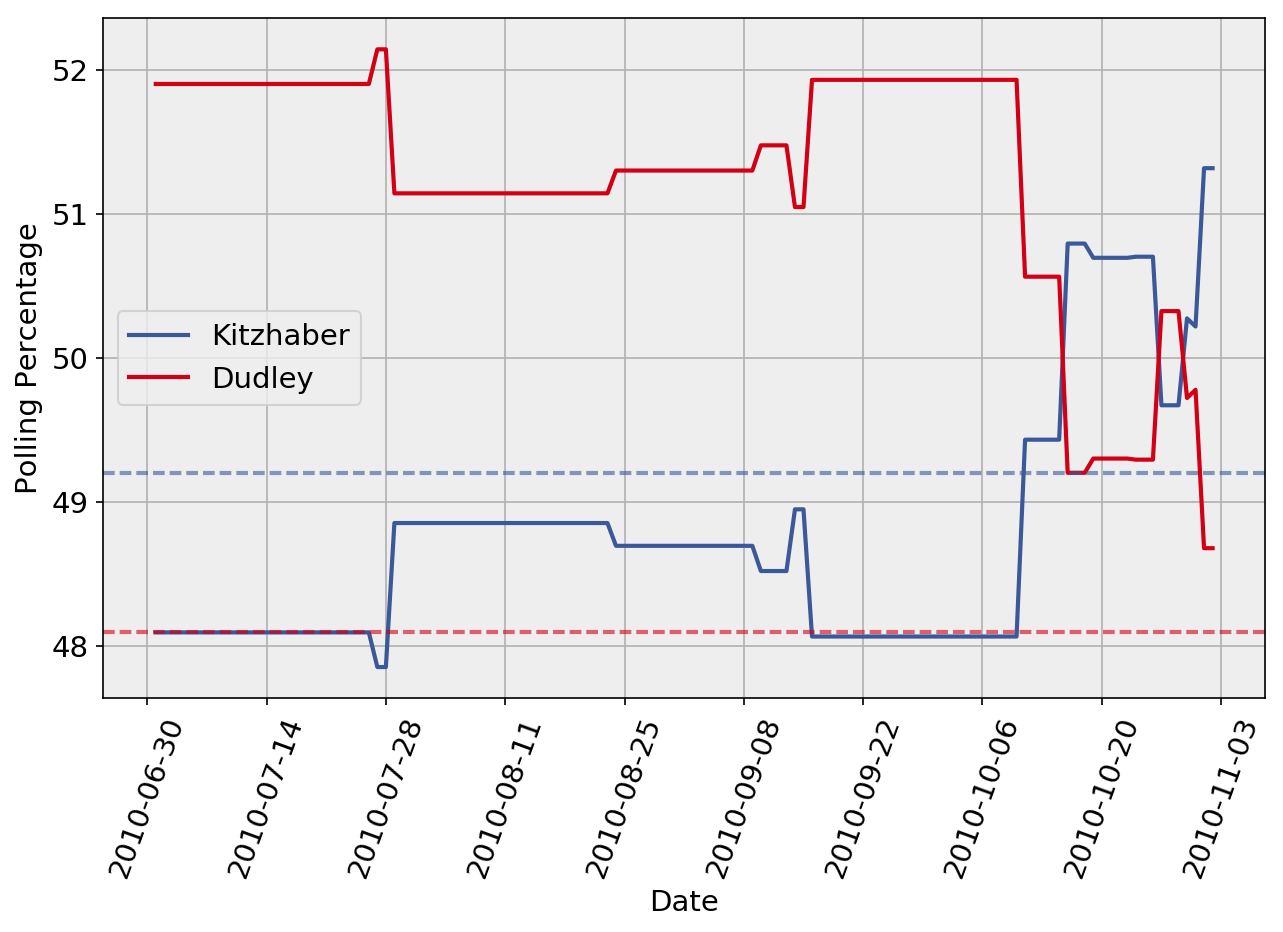

1232


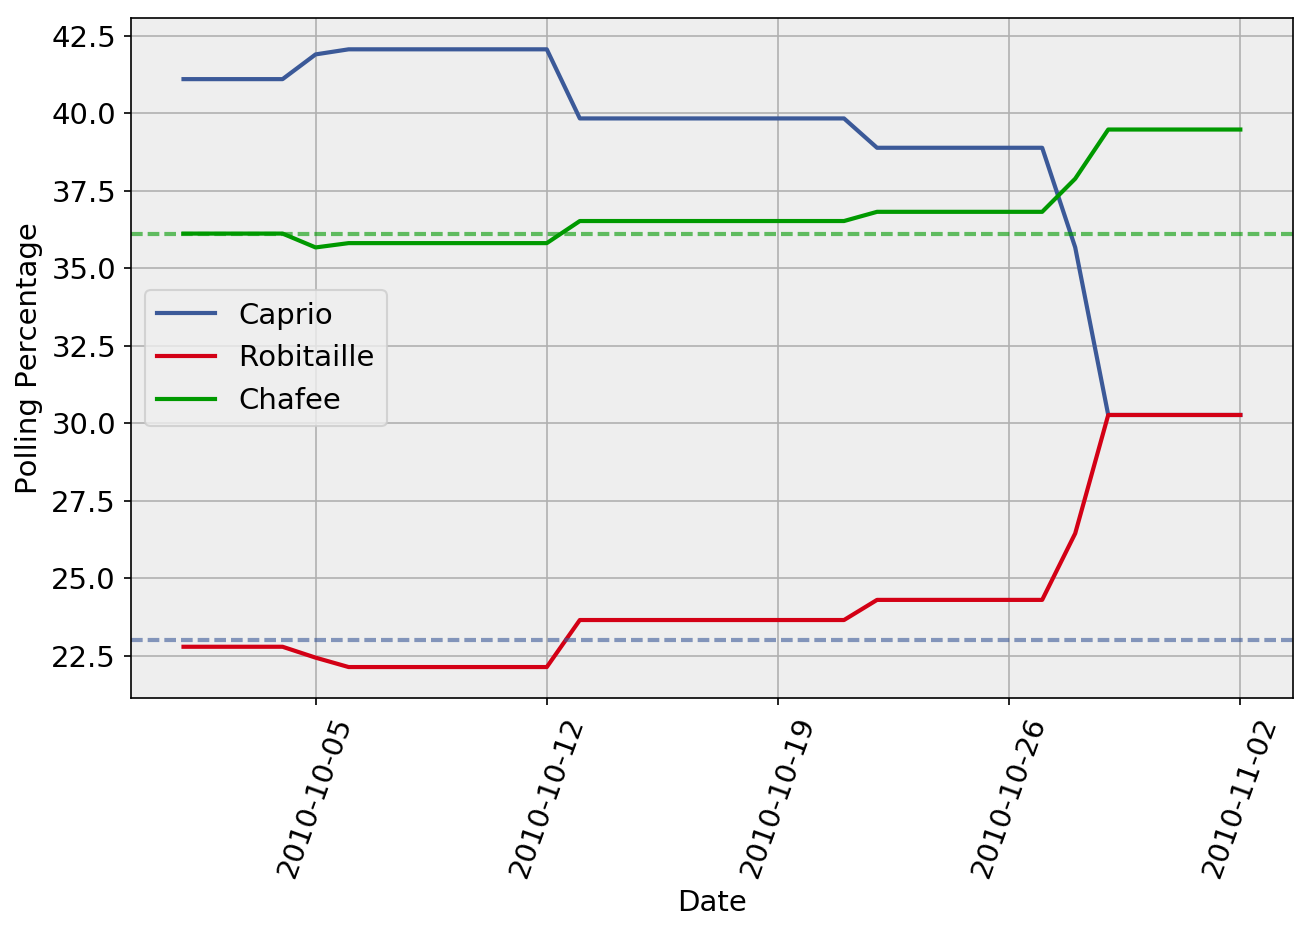

1228
1409


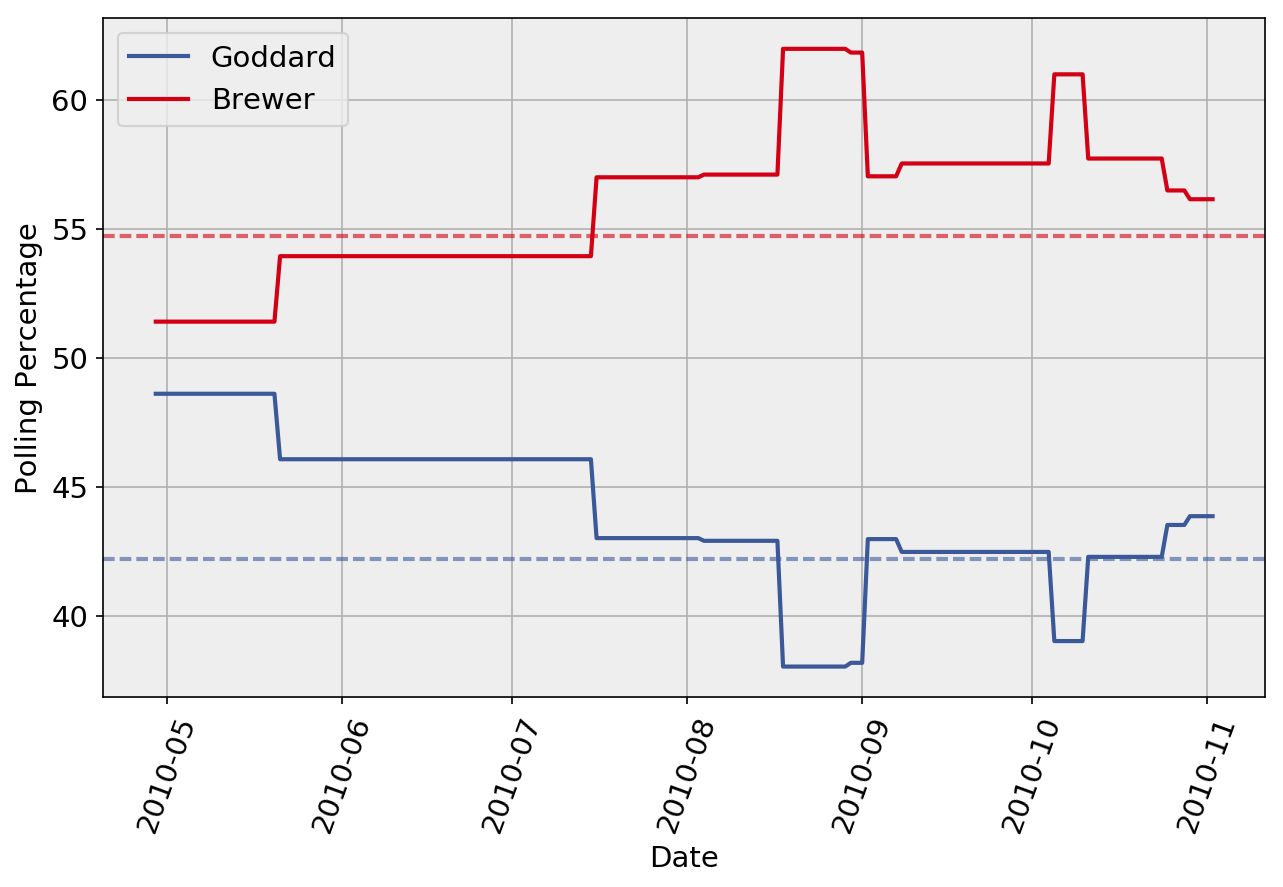

1316


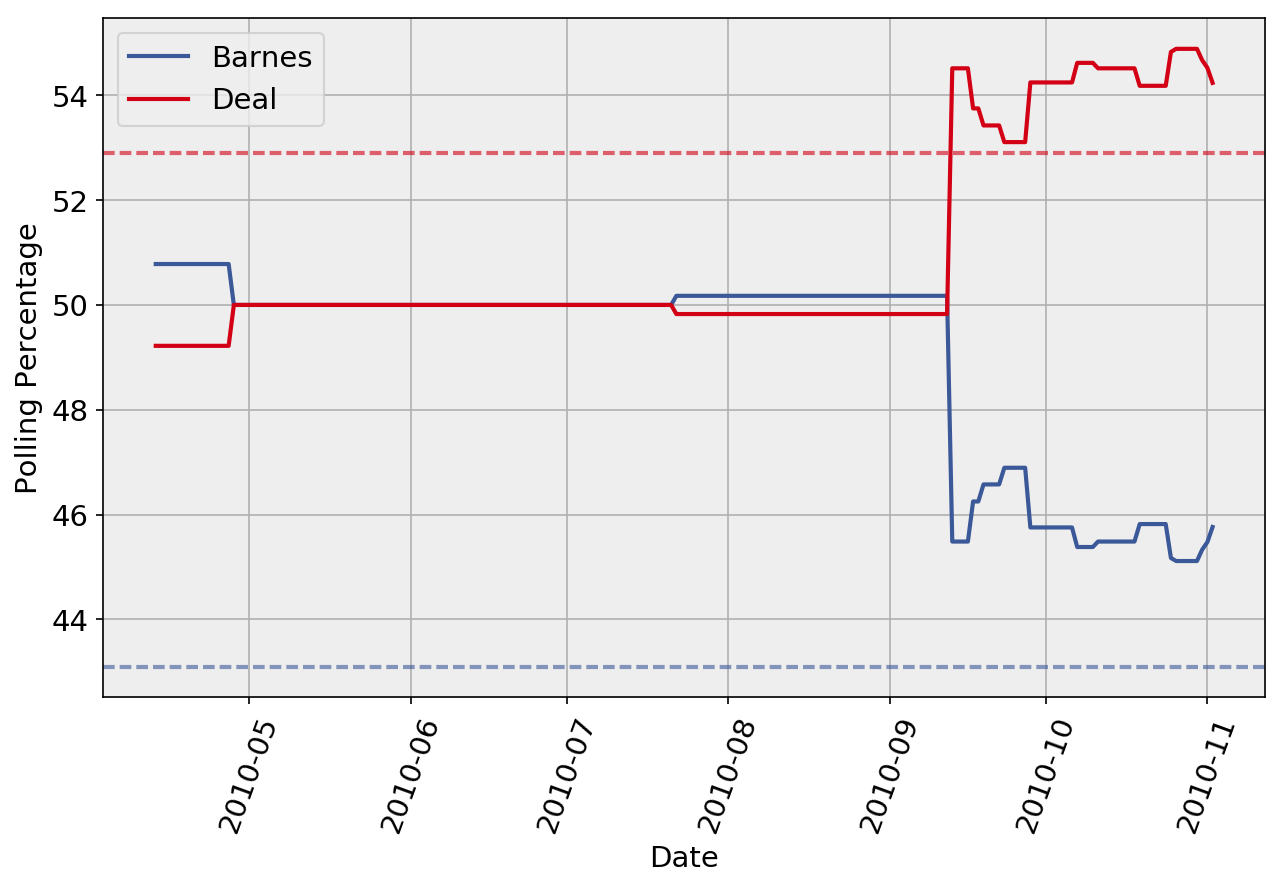

1323


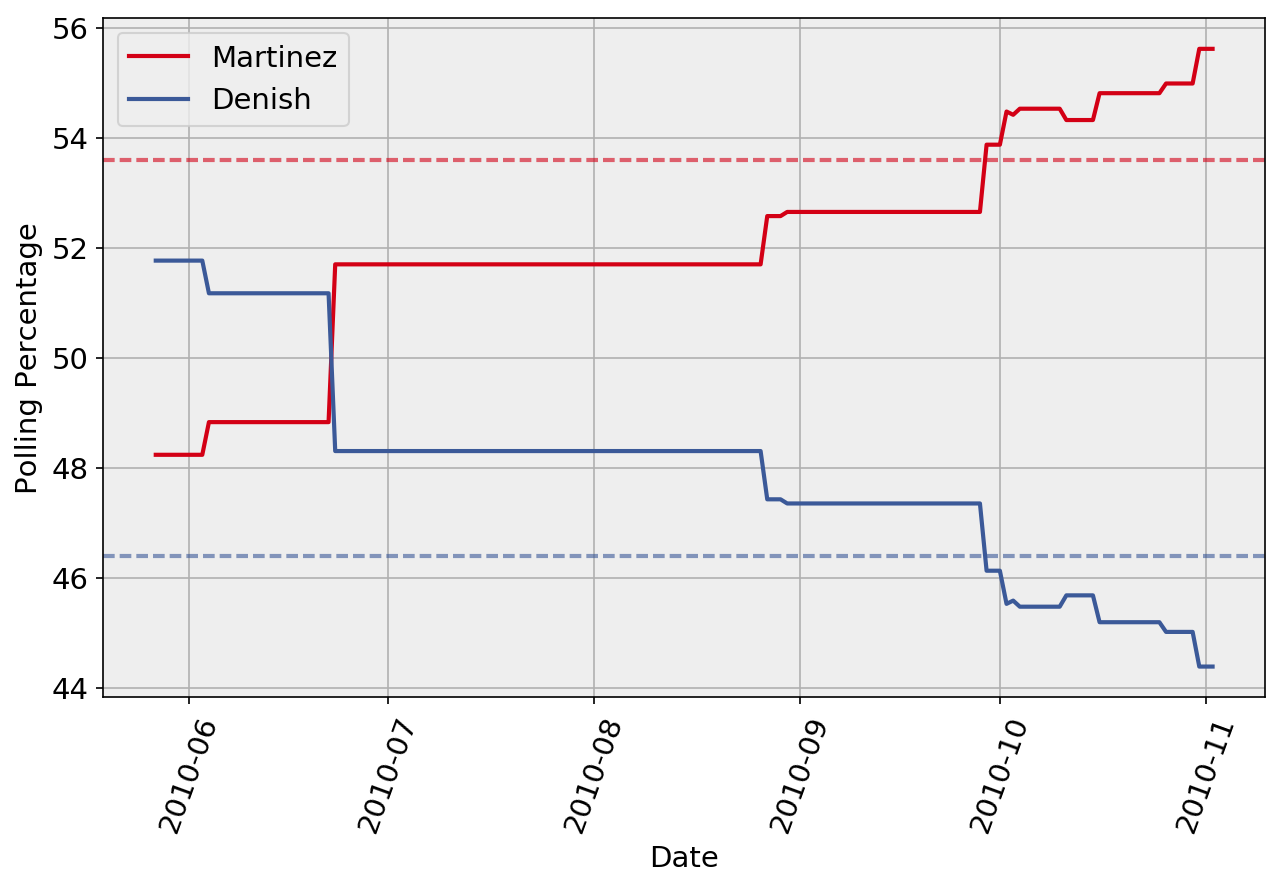

1333


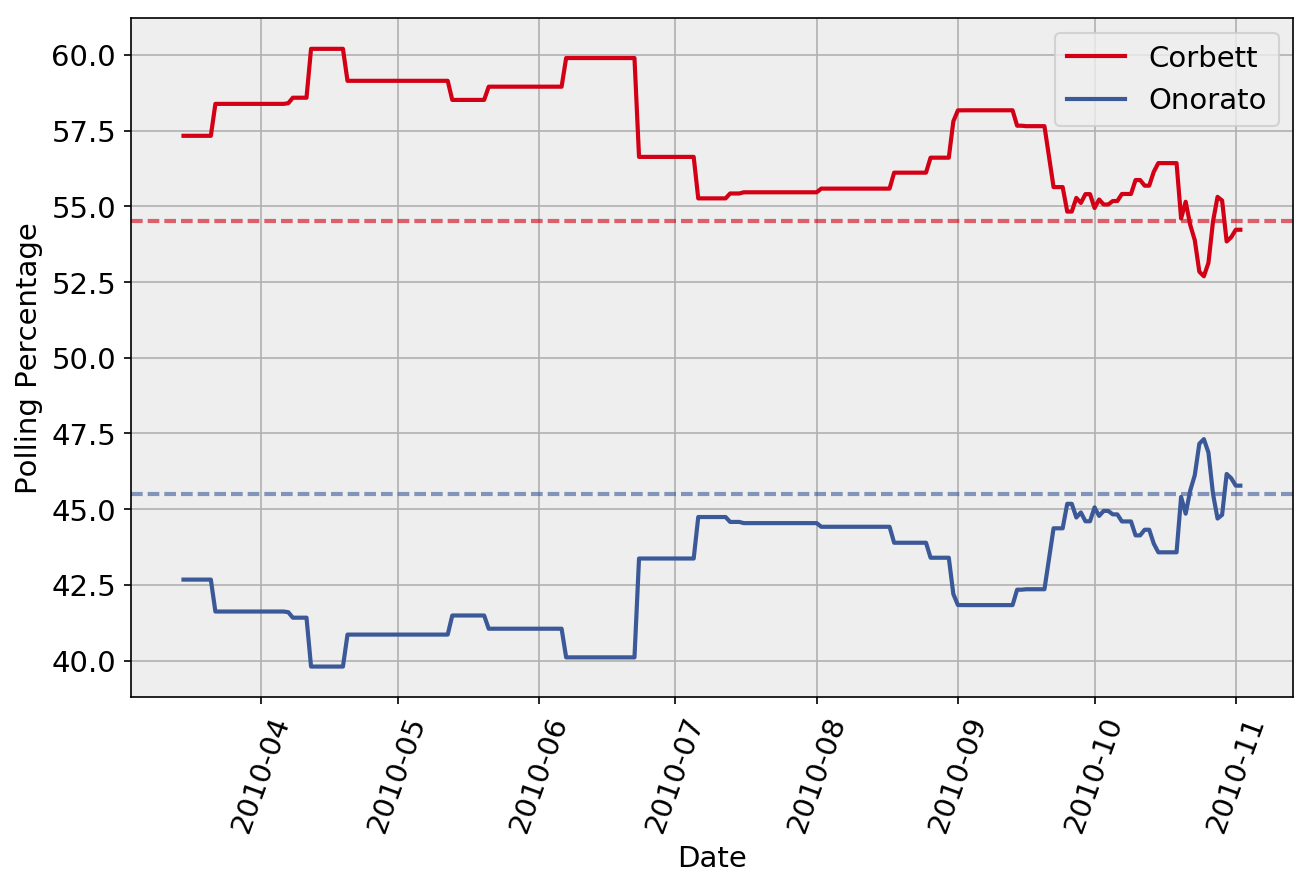

1574


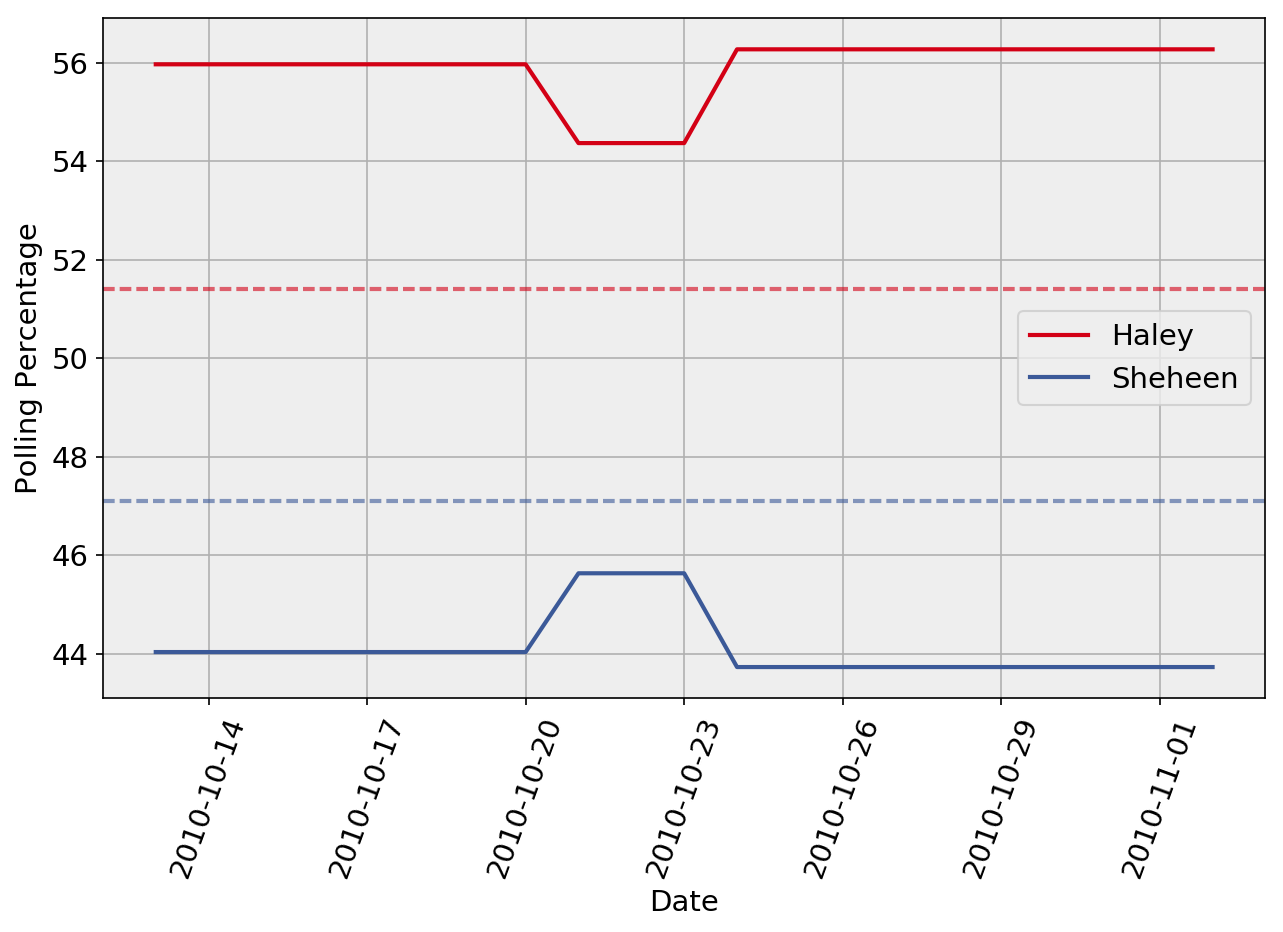

1194


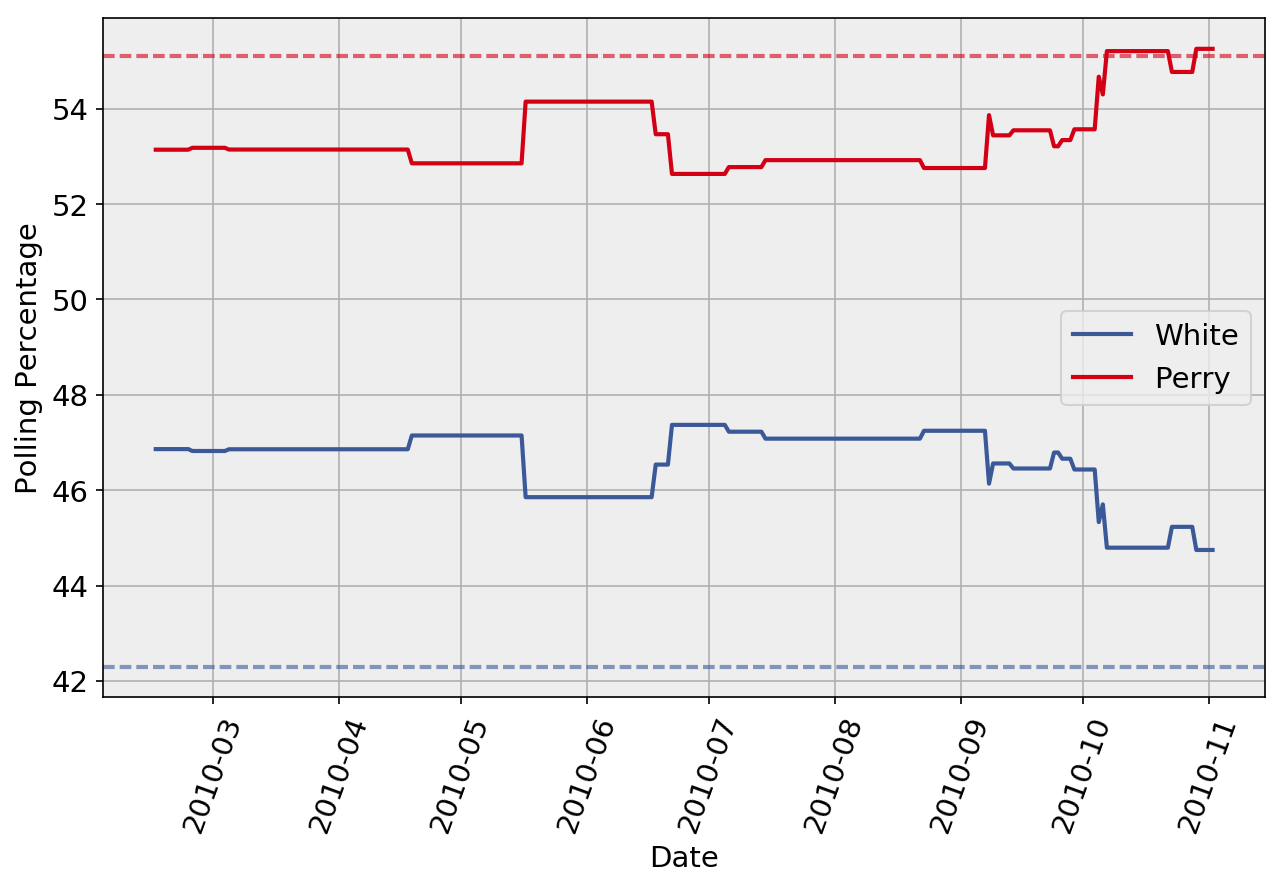

1184


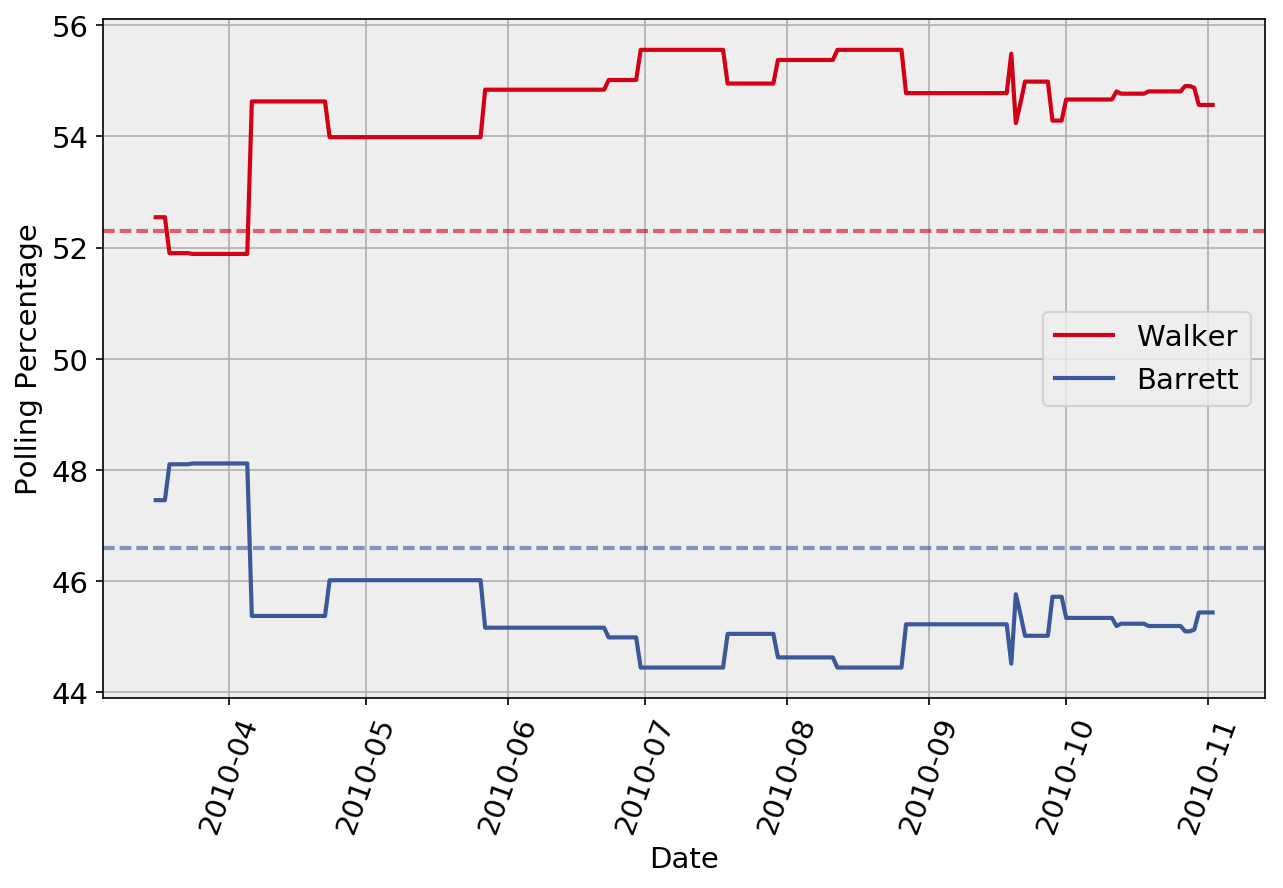

1510


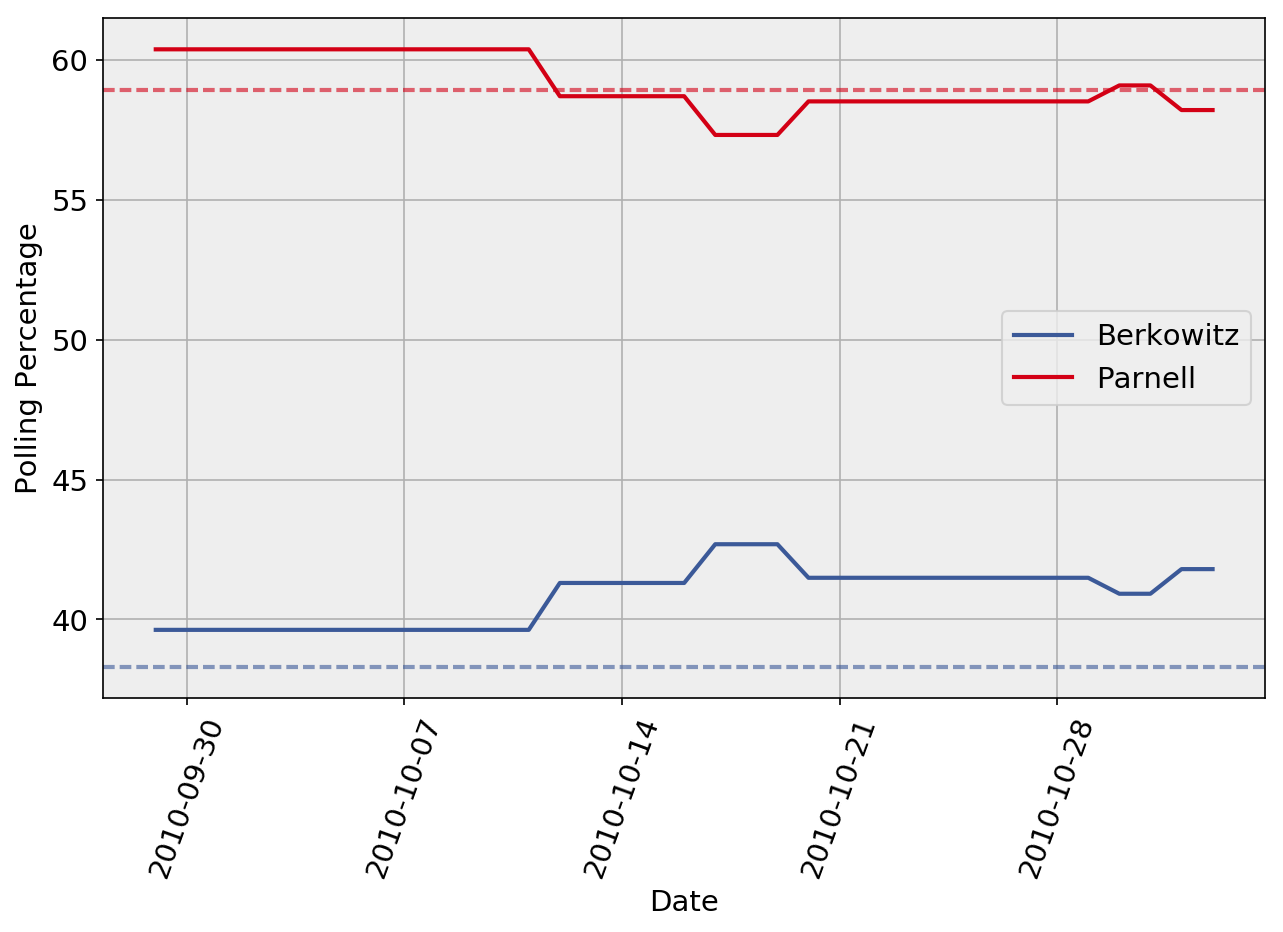

1200


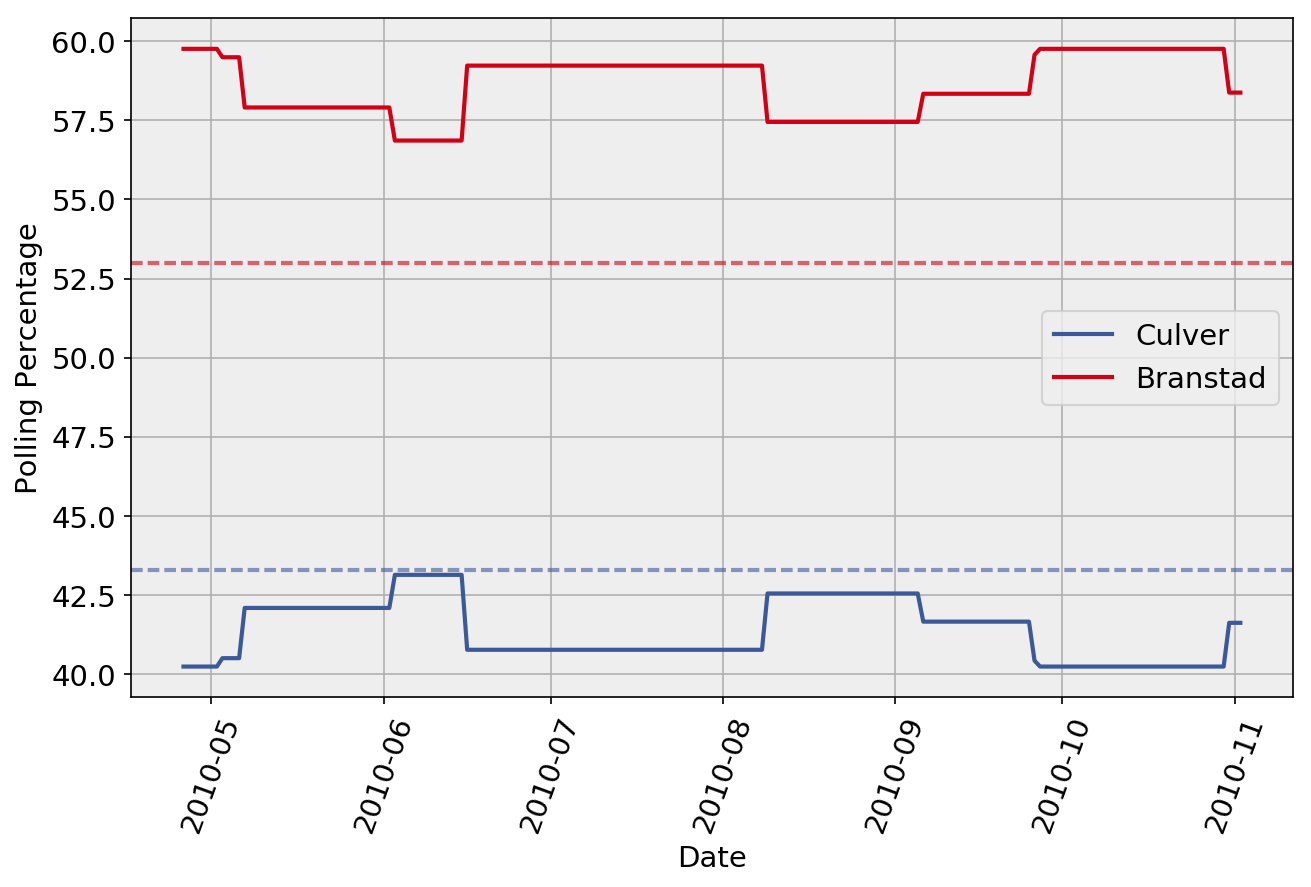

1231


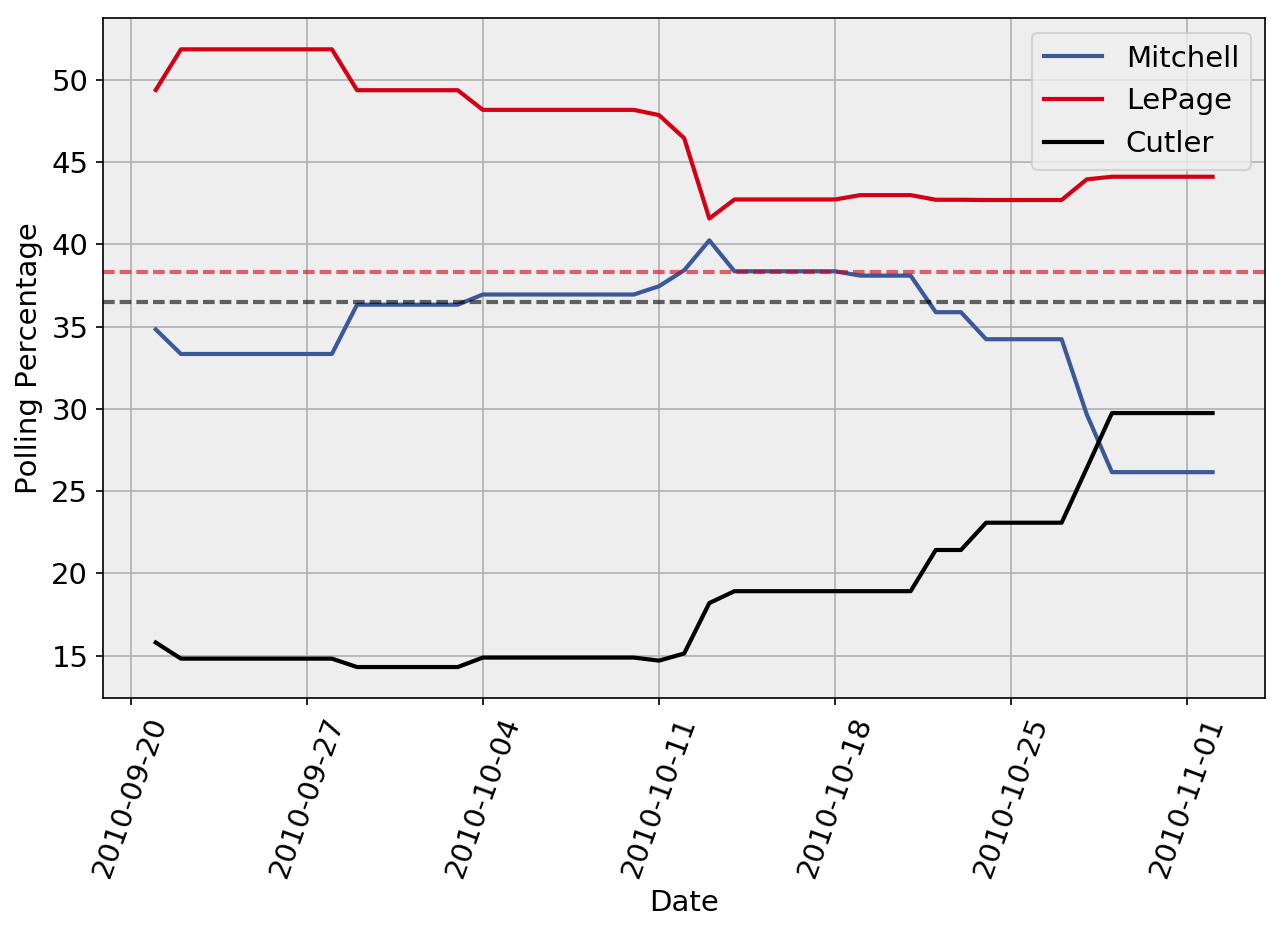

1407


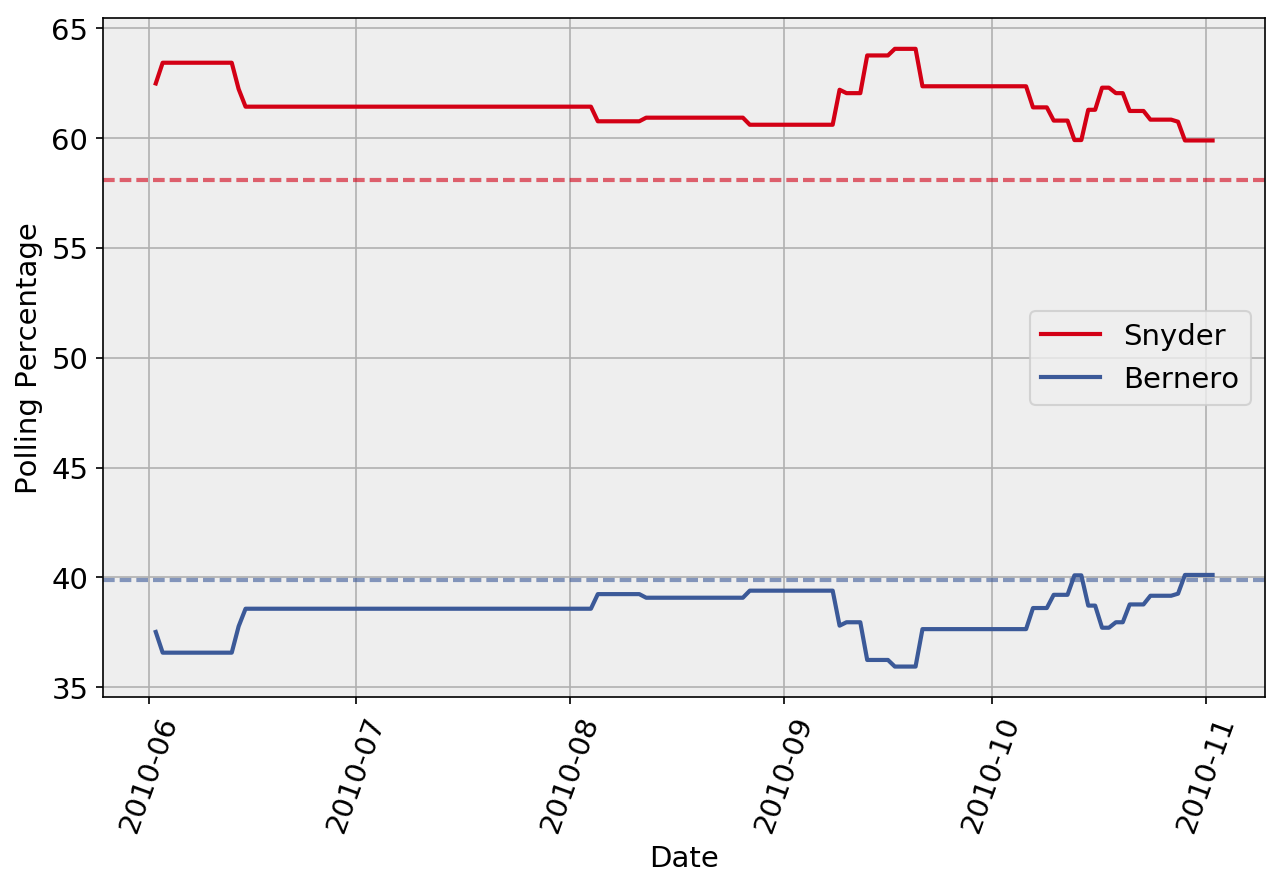

1137


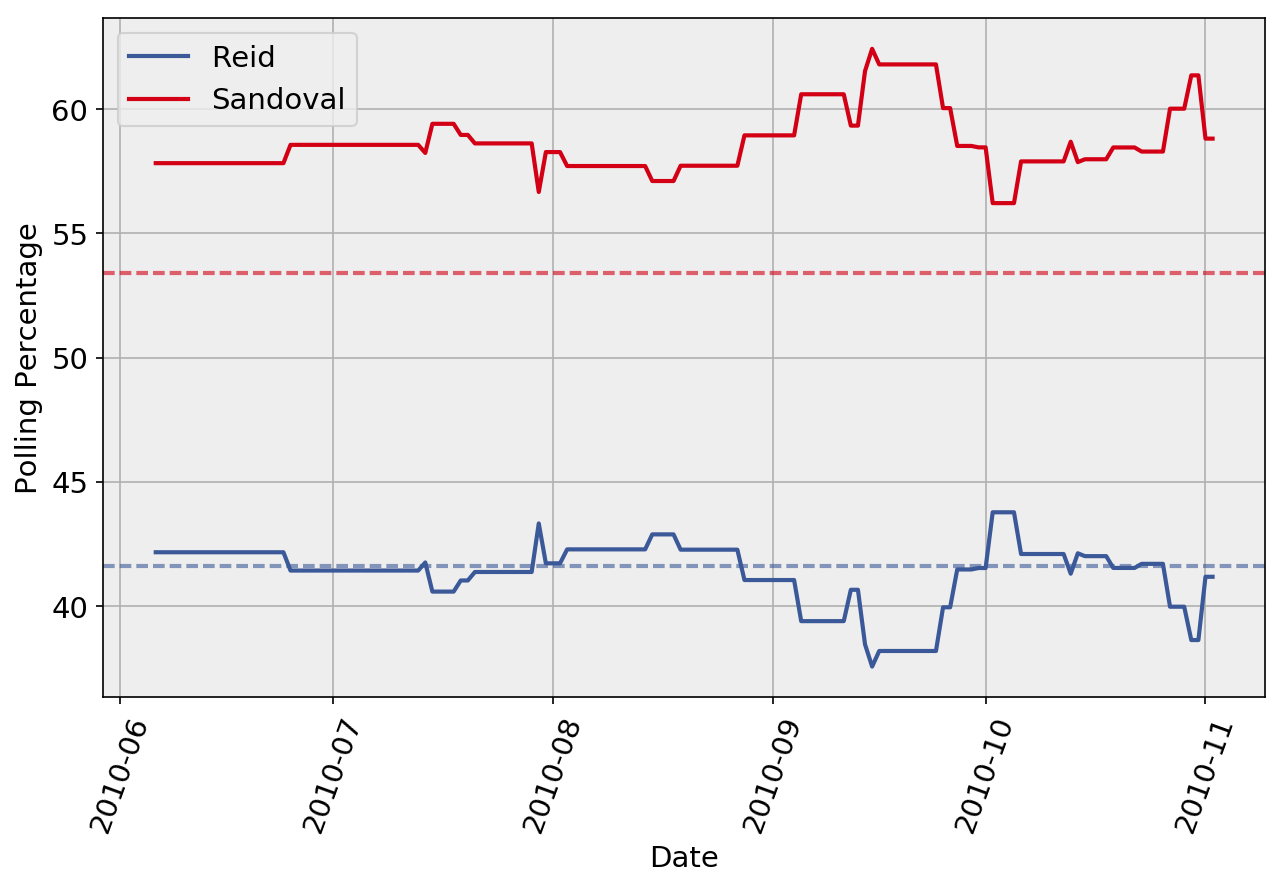

In [33]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')

for race in find_governor_races(page):
    plot_race(race)
    plt.show()

Briefly summarize these graphs -- how accurate is the typical poll a day before the election? How often does a prediction one month before the election mispredict the actual winner?

**Your summary here**

---

## Part 3: Analysis

#### Problem 5

You are (finally!) in a position to do some quantitative analysis.

We have provided an `error_data` function that builds upon the functions you have written. It computes a new DataFrame with information about polling errors.

Use `error_data`, `find_governer_races`, and `pd.concat` to construct a Data Frame summarizing the forecast errors
from all the Governor races

**Hint** 

It's best to set `ignore_index=True` in `pd.concat`

In [258]:
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'


def error_data(url):
    """
    Given a Governor race URL, download the poll data and race result,
    and construct a DataFrame with the following columns:
    
    candidate: Name of the candidate
    forecast_length: Number of days before the election
    percentage: The percent of poll votes a candidate has.
                Normalized to that the canddidate percentages add to 100%
    error: Difference between percentage and actual race reulst
    party: Political party of the candidate
    
    The data are resampled as necessary, to provide one data point per day
    """
    
    id = id_from_url(url)
    xml = get_poll_xml(id)
    
    colors = plot_colors(xml)
    if len(colors) == 0:
        return pd.DataFrame()
    
    df = rcp_poll_data(xml)
    result = race_result(url)
       
        
    #remove non-letter characters from columns
    df = df.rename(columns={c: _strip(c) for c in df.columns})
    for k, v in result.items():
        result[_strip(k)] = v 
    

    candidates = [c for c in df.columns if c is not 'date']
       
    #turn into a timeseries...
    df.index = df.date
    #print df.head()    
    #...so that we can resample at regular, daily intervals
    df = df.resample('D')
    #print df.head()    
    df = df.dropna()
    ###########################the resample operation is losing the .date column http://stackoverflow.com/questions/21878599/pandas-drops-timestamp-columns-in-resample
    #compute forecast length in days
    #(assuming that last forecast happens on the day of the election, for simplicity)
    #forecast_length = (df.date.max() - df.date).values
    #forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    forecast_length = (df.index.max() - df.index).values
    #print forecast_length
    forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days
    #print forecast_length
    
    #compute forecast error
    errors = {}
    normalized = {}
    poll_lead = {}
    
    #print candidates
    #print result
    for c in candidates:
        #turn raw percentage into percentage of poll votes
        corr = df[c].values / df[candidates].sum(axis=1).values * 100.
        #print c
        #print corr
        err = corr - result[_strip(c)]
        
        normalized[c] = corr
        errors[c] = err
        
    n = forecast_length.size
    
    result = {}
    result['percentage'] = np.hstack(normalized[c] for c in candidates)
    result['error'] = np.hstack(errors[c] for c in candidates)
    result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
    result['party'] = np.hstack(np.repeat(party_from_color(colors[_strip(c)]), n) for c in candidates)
    result['forecast_length'] = np.hstack(forecast_length for _ in candidates)
    
    result = pd.DataFrame(result)
    return result

In [259]:
"""
function
---------
all_error_data

Calls error_data on all races from find_governer_races(page),
and concatenates into a single DataFrame

Parameters
-----------
None

Examples
--------
df = all_error_data()
"""
def all_error_data():
    governor_races = find_governor_races(requests.get("http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html").text)
    result = pd.DataFrame()
    for link in governor_races:
        new_data = error_data(link)
        result = pd.concat([result, new_data], ignore_index=True)
    return result

#print governor_races[1]

note: solution had much more elegant and compact version

In [260]:
errors = all_error_data()

/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:79: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/ben/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: FutureWarning: 
.resample() is now a deferred operation
You called dropna(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead


Here's a histogram of the error of every polling measurement in the data

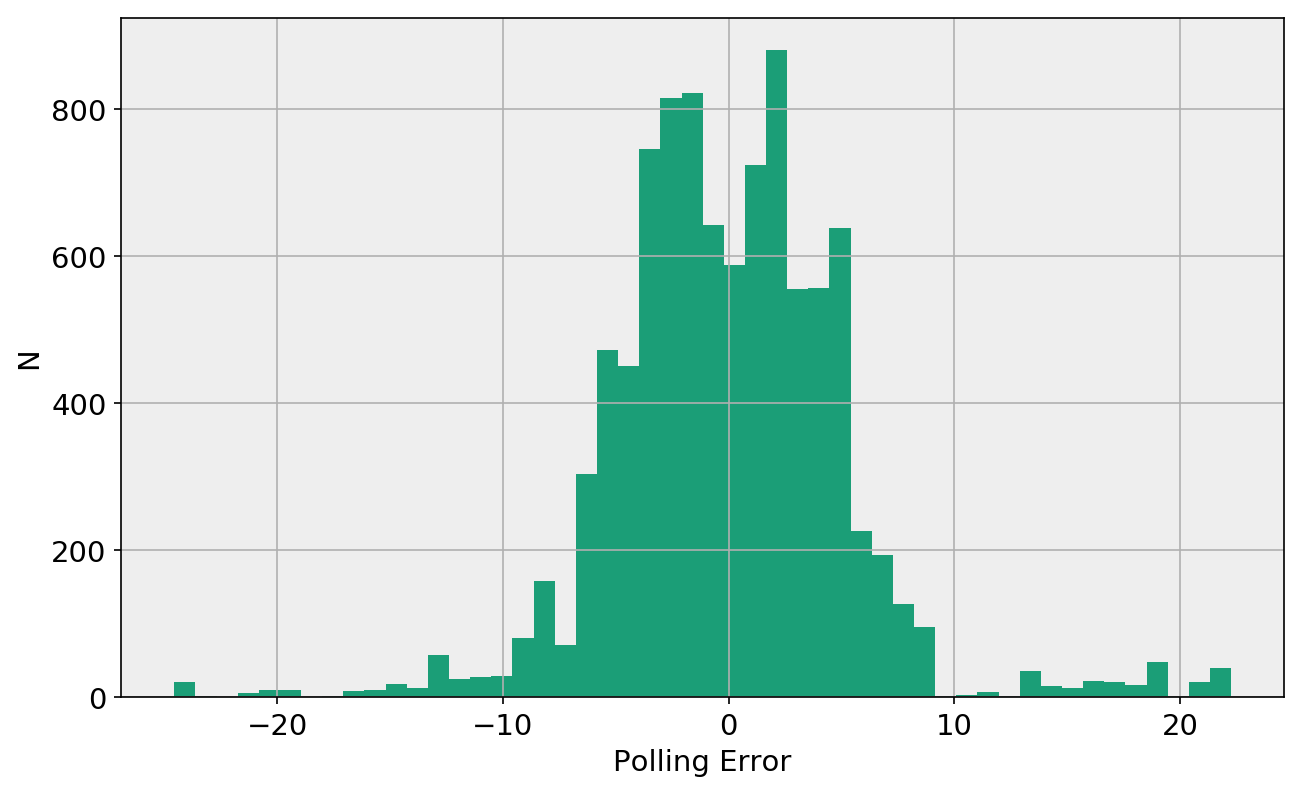

In [241]:
errors.error.hist(bins=50)
plt.xlabel("Polling Error")
plt.ylabel('N')

### Problem 6

Compute the standard deviation of the polling errors. How much uncertainty is there in the typical RCP poll?

In [242]:
#your code here
errors.error.std(axis = 0)

5.271742498957227

### Problem 7

Repeat this calculation for the data where `errors.forecast_length < 7` (i.e. the polls within a week of an election). How much more/less accurate are they? How about the data where `errors.forecast_length > 30`? 

**Comment on this in 1 or 2 sentences**. Does this make sense?

In [243]:
#your code here
print errors[errors.forecast_length < 7 ].error.std(axis = 0)
print errors[errors.forecast_length > 30 ].error.std(axis = 0)

3.23012425049
5.33268143365


### Problem 8

**Bootstrap resampling** is a general purpose way to use empirical data like the `errors` DataFrame to estimate uncertainties. For example, consider the [Viriginia Governor Race](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html). If we wanted to estimate how likey it is that McAuliffe will win given the current RCP data, the approch would be:

1. Pick a large number N of experiments to run (say N=1000).
2. For each experiment, randomly select a value from `errors.error`. We are assuming that these numbers represent a reasonable error distribution for the current poll data.
3. Assume that the error on McAullife's current polling score is given by this number (and, by extension, the error on Cuccinelli's poll score is the opposite). Calculate who actually wins the election in this simulation.
4. Repeat N times, and calculate the percentage of simulations where either candidate wins.

Bootstrapping isn't foolproof: it makes the assumption that the previous Governor race errors are representative of the Virginia race, and it does a bad job at estimating very rare events (with only ~30 races in the errors DataFrame, it would be hard to accurately predict probabilities for 1-in-a-million scenarios). Nevertheless, it's a versatile technique.

Use bootstrap resampling to estimate how likely it is that each candidate could win the following races.

 * [Virginia Governor](http://www.realclearpolitics.com/epolls/2013/governor/va/virginia_governor_cuccinelli_vs_mcauliffe-3033.html)
 * [New Jersey Governor](http://www.realclearpolitics.com/epolls/2013/governor/nj/new_jersey_governor_christie_vs_buono-3411.html)
 
**Summarize your results in a paragraph. What conclusions do you draw from the bootstrap analysis, and what assumptions did you make in reaching this conclusion. What are some limitations of this analysis?**
 

In [254]:
#your code here
    
def get_winner(name_one, name_two, percent_one, percent_two):
    poll_df = pd.DataFrame([(percent_one, percent_two)], columns = [name_one, name_two])

    #normalize
    poll_df = poll_df / float(poll_df.sum(axis=1).values[0]) * 100

    victor = pd.DataFrame([(0,0)], columns = [name_one, name_two])
    n_trials = 10000
    for trial in range(n_trials):
        error = errors.error.sample().values[0]
        if poll_df.iloc[0][0] - error >= 50:
            victor.iloc[0][0]+=1
        else:
            victor.iloc[0][1]+=1
    print victor / float(n_trials)

    if victor.iloc[0][0] > victor.iloc[0][1]:
        print "winner: %s"  % victor.columns[0]
    elif victor.iloc[0][0] < victor.iloc[0][1]:
        print "winner: %s"  % victor.columns[1]
    else:
        print "tie"   
    
    return

get_winner("C", "M", 39.0, 43.0)
get_winner("C", "B", 55.4, 31.8)


        C       M
0  0.3142  0.6858
winner: M
        C       B
0  0.9789  0.0211
winner: C


**Your summary here**

## Parting Thoughts

For comparison, most of the predictions in Nate Silver's [presidental forecast](http://fivethirtyeight.blogs.nytimes.com/fivethirtyeights-2012-forecast/) had confidences of >95%. This is more precise than what we can estimate from the RCP poll alone. His approach, however, is the same basic idea (albeit he used many more polls, and carefully calibrated each based on demographic and other information). Homework 2 will dive into some of his techniques further.


## How to submit

To submit your homework, create a folder named lastname_firstinitial_hw0 and place this notebook file in the folder. If your notebook requires any additional data files to run (it shouldn't), add them to this directory as well. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work.

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>